<a href="https://colab.research.google.com/github/sina-salmanpour/Loan_Defaults_prediction/blob/main/Loan_Defaults.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Libraries

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

import warnings
from IPython.core.interactiveshell import InteractiveShell

Libraries initial settings

In [78]:
## Following lines are used to control how warnings are displayed.

warnings.filterwarnings('ignore')
warnings.simplefilter(action="ignore", category=FutureWarning)  # warnings about features that will change in the future.
warnings.simplefilter(action="ignore", category=Warning)        # more general category for warnings.


## Setting below is related to how IPython displays output.
## The results of all statements in a cell that would normally be displayed are shown

InteractiveShell.ast_node_interactivity = "all"

# matplotlib plots are displayed directly within the notebook output

%matplotlib inline
np.set_printoptions(suppress=True)
plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams['figure.dpi'] = 100

sns.set_style("whitegrid")

def set_seed(seed=42):
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

pd.set_option("display.width", 100)
pd.set_option("display.max_columns", 60)
pd.set_option("display.max_rows", 25)
pd.set_option("display.float_format", lambda x: "%.3f" % x)


#Loading Dataset

In [79]:
df = pd.read_csv('/content/drive/MyDrive/Loan Defaults/Dataset ARCHIVE/Training Data.csv')

Checking for missing values and duplicated values

In [80]:
# Check for missing values
missing_values = df.isnull().sum()
if missing_values.sum() == 0:
    print("No missing values found in the dataset.")
else:
    print("Missing Values:")
    print(missing_values[missing_values > 0])

    # Calculate missing value percentages
    missing_percent = (missing_values / len(df)) * 100
    print("\nMissing Value Percentages:")
    print(missing_percent[missing_percent > 0])

No missing values found in the dataset.


In [81]:
# Check for duplicate rows
duplicate_rows = df.duplicated().sum()
if duplicate_rows == 0:
    print("\nNo duplicate rows found in the dataset.")
else:
    print(f"\nNumber of duplicate rows found: {duplicate_rows}")


No duplicate rows found in the dataset.


## Initial inspection

In [82]:
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())
print("\nTarget variable distribution:")
print(df['Risk_Flag'].value_counts())

Dataset Shape: (252000, 13)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252000 entries, 0 to 251999
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Id                 252000 non-null  int64 
 1   Income             252000 non-null  int64 
 2   Age                252000 non-null  int64 
 3   Experience         252000 non-null  int64 
 4   Married/Single     252000 non-null  object
 5   House_Ownership    252000 non-null  object
 6   Car_Ownership      252000 non-null  object
 7   Profession         252000 non-null  object
 8   CITY               252000 non-null  object
 9   STATE              252000 non-null  object
 10  CURRENT_JOB_YRS    252000 non-null  int64 
 11  CURRENT_HOUSE_YRS  252000 non-null  int64 
 12  Risk_Flag          252000 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 25.0+ MB
None

First 5 rows:
   Id   Income  Age  Experience Married/Single House_Ow

In [83]:
print("Summary Statistics (Numerical Features):\n")
df.describe().T   # For Numerical variables

Summary Statistics (Numerical Features):



,count,mean,std,min,25%,50%,75%,max
Id,252000.000,126000.500,72746.278,1.000,63000.750,126000.500,189000.250,252000.000
Income,252000.000,4997116.665,2878311.014,10310.000,2503015.000,5000694.500,7477502.000,9999938.000
Age,252000.000,49.954,17.064,21.000,35.000,50.000,65.000,79.000
Experience,252000.000,10.084,6.003,0.000,5.000,10.000,15.000,20.000
CURRENT_JOB_YRS,252000.000,6.334,3.647,0.000,3.000,6.000,9.000,14.000
CURRENT_HOUSE_YRS,252000.000,11.998,1.399,10.000,11.000,12.000,13.000,14.000
Risk_Flag,252000.000,0.123,0.328,0.000,0.000,0.000,0.000,1.000


In [84]:
print("Summary Statistics (Categorical Features):\n")
df.describe(include='object').T   # For categorical variables

Summary Statistics (Categorical Features):



,count,unique,top,freq
Married/Single,252000,2,single,226272
House_Ownership,252000,3,rented,231898
Car_Ownership,252000,2,no,176000
Profession,252000,51,Physician,5957
CITY,252000,317,Vijayanagaram,1259
STATE,252000,29,Uttar_Pradesh,28400


In [85]:
df_copy = df.copy()   # Copy dataframe in case we need original one

#Exploritory Data Analysis (EDA)

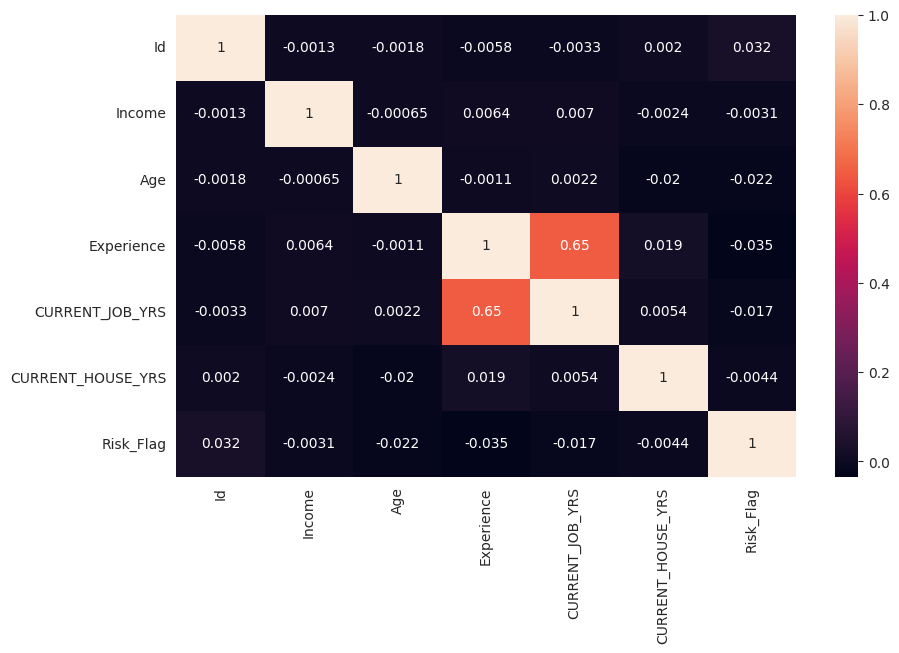

In [86]:
# Select only numerical columns for correlation calculation
df_numeric = df.select_dtypes(include=np.number)

# Calculate and plot the heatmap for numerical columns
sns.heatmap(df_numeric.corr(), annot=True);

###ID feature

In [87]:
df.drop("Id", axis=1, inplace=True)


Based on heatmap, there is no correlation between ID column and other features. It's just row identifier. WE should drop this column.

In [88]:
# Creating numerical plotting function to plot more easily.

def numerical_plotting(data, col, title, symb, ylabel, color):
    fig, ax = plt.subplots(2, 1,
                           sharex=True,
                           figsize=(20, 8),
                           facecolor="#FFFFFF",
                           gridspec_kw={"height_ratios": (.2, .8)})

    ax[0].set_facecolor("#FFFFFF")
    ax[1].set_facecolor("#FFFFFF")

    ax[0].set_title(title,
                    weight="bold",
                    fontsize=30,
                    pad=30)

    sns.boxplot(x=col,
                data=data,
                color=color,
                ax=ax[0])

    ax[0].set(yticks=[])

    sns.distplot(data[col], kde=True, color=color)

    plt.xticks(weight="bold", fontsize=10)
    plt.yticks(weight="bold", fontsize=10)

    ax[0].set_xlabel(col, weight="bold", fontsize=15, labelpad=15)
    ax[1].set_xlabel(col, weight="bold", fontsize=15)
    ax[1].set_ylabel(ylabel, weight="bold", fontsize=15)

    plt.axvline(data[col].mean(),
                color='darkgreen',
                linewidth=2.2,
                label='mean=' + str(np.round(data[col].mean(),1)) + symb)
    plt.axvline(data[col].median(),
                color='red',
                linewidth=2.2,
                label='median='+ str(np.round(data[col].median(),1)) + symb)
    plt.axvline(data[col].max(),
                color='blue',
                linewidth=2.2,
                label='max='+ str(np.round(data[col].max(),1)) + symb)
    plt.axvline(data[col].min(),
                color='orange',
                linewidth=2.2,
                label='min='+ str(np.round(data[col].min(),1)) + symb)
    plt.axvline(data[col].mode()[0],
                color='purple',
                linewidth=2.2,
                label='mode='+ str(data[col].mode()[0]) + symb)


    plt.legend(bbox_to_anchor=(1, 1),
               ncol=1,
               fontsize=17,
               fancybox=True,
               shadow=True,
               frameon=False)

    plt.tight_layout()
    plt.show()


###Income

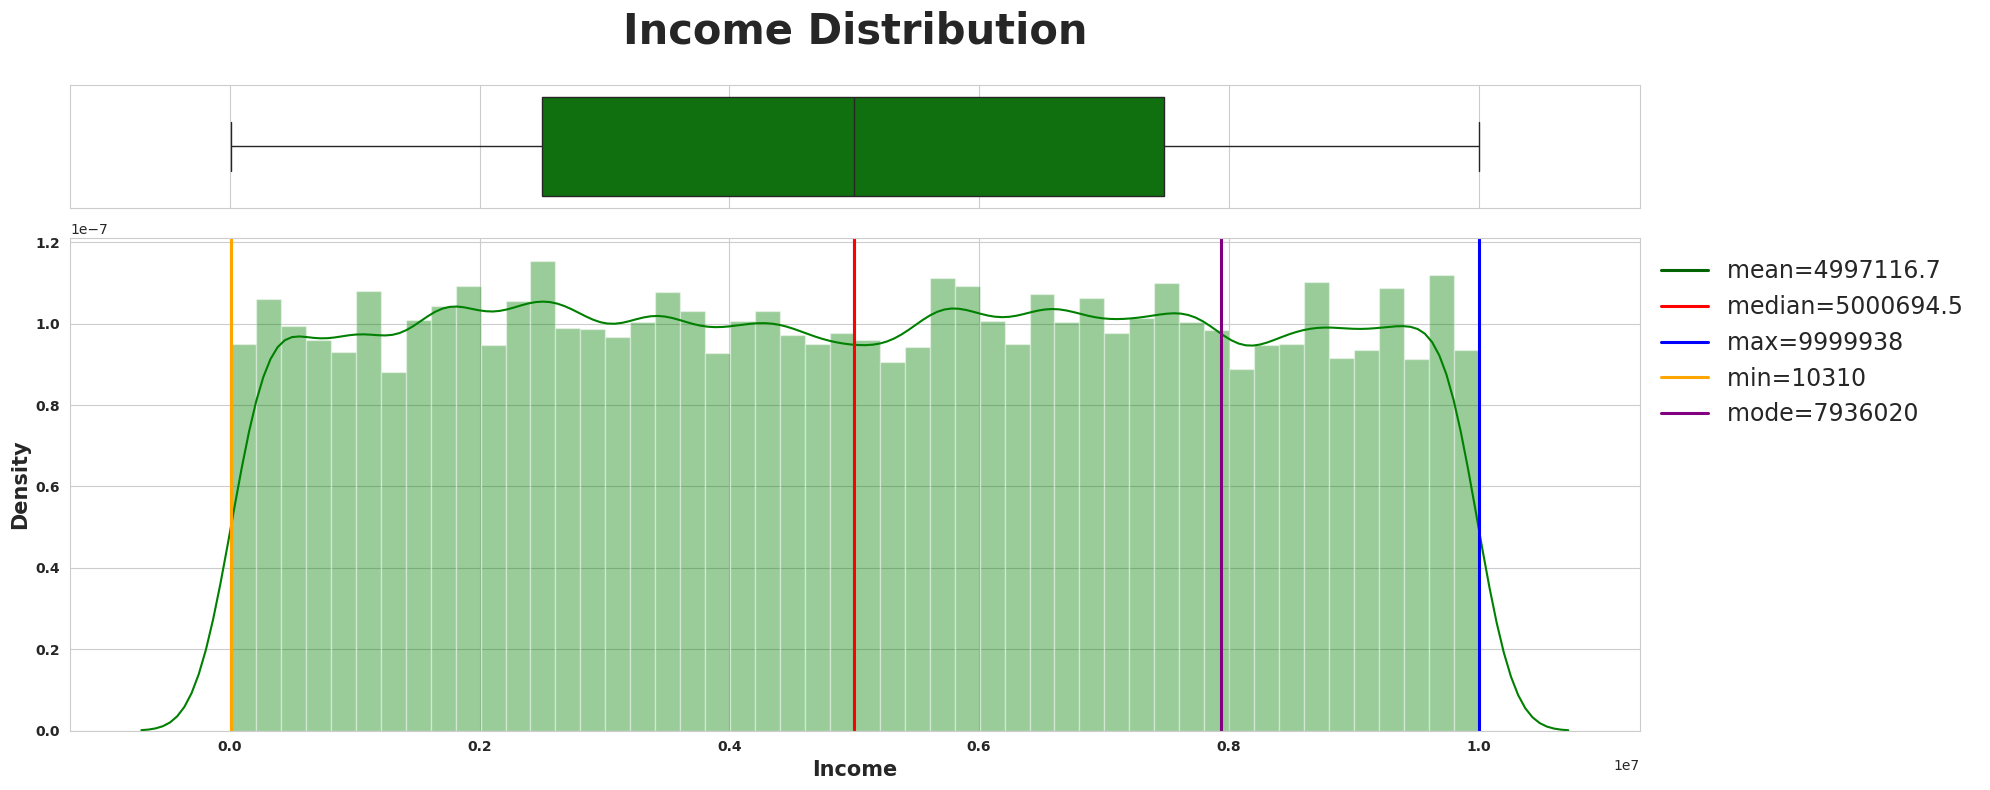

In [89]:
numerical_plotting(data=df, col="Income",
                   title="Income Distribution",
                   symb=" ", ylabel="Density", color="green");

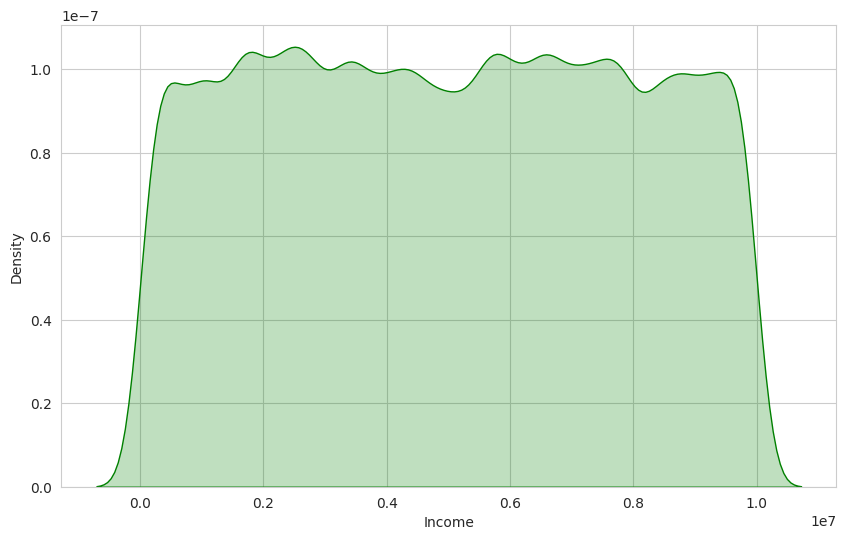

In [90]:
sns.kdeplot(df.Income, color='green',shade=True);

A KDE plot is a way to visualize the distribution of a single numerical variable. It shows the probability density function of the data, which can help you understand the shape of the distribution, identify peaks (modes), and see the spread of the data. In this case, it will show you the distribution of income values in your dataset.

In [91]:
df.groupby("Profession")["Income"].agg(["min", "max", "mean", "std"]).sort_values(by="mean", ascending=False)

"""
This line of code is performing an analysis of the Income column based on the Profession
of individuals in your dataset.
"""

,min,max,mean,std
Profession,,,,
Petroleum_Engineer,22921,9968353,5443309.827,2947683.213
Psychologist,33224,9985964,5357795.262,2815681.793
Designer,12841,9996946,5336802.230,2955188.103
Scientist,13792,9975985,5282710.423,2861046.111
Surgeon,18215,9995445,5235358.713,2831574.156
...,...,...,...,...
Civil_engineer,25674,9992141,4755441.023,2811661.895
Official,13629,9993041,4737617.356,2933763.750
Drafter,14936,9999180,4654804.628,2789440.541


'\nThis line of code is performing an analysis of the Income column based on the Profession\nof individuals in your dataset.\n'

###Age

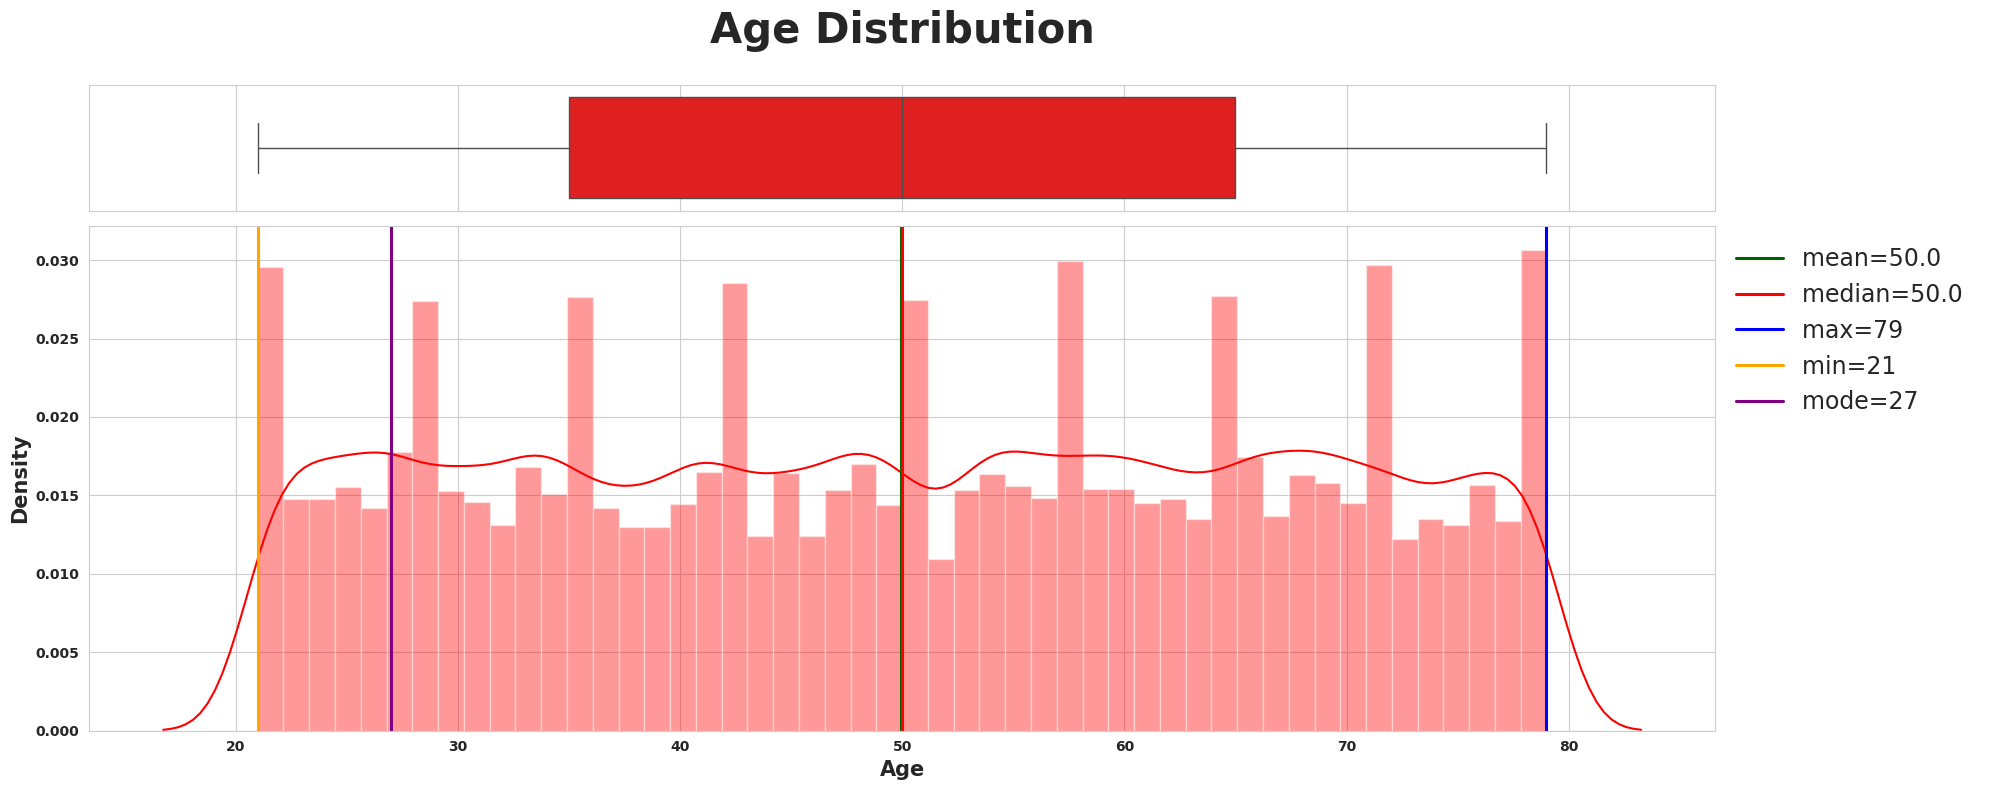

In [92]:
numerical_plotting(data=df, col="Age",
                   title="Age Distribution",
                   symb=" ", ylabel="Density", color="red");

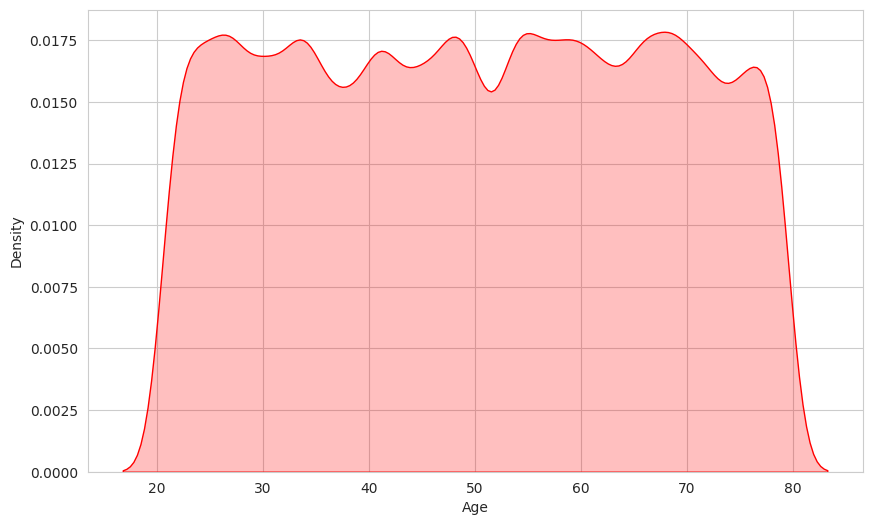

In [93]:
sns.kdeplot(df.Age, color='red',shade=True);

###Experience

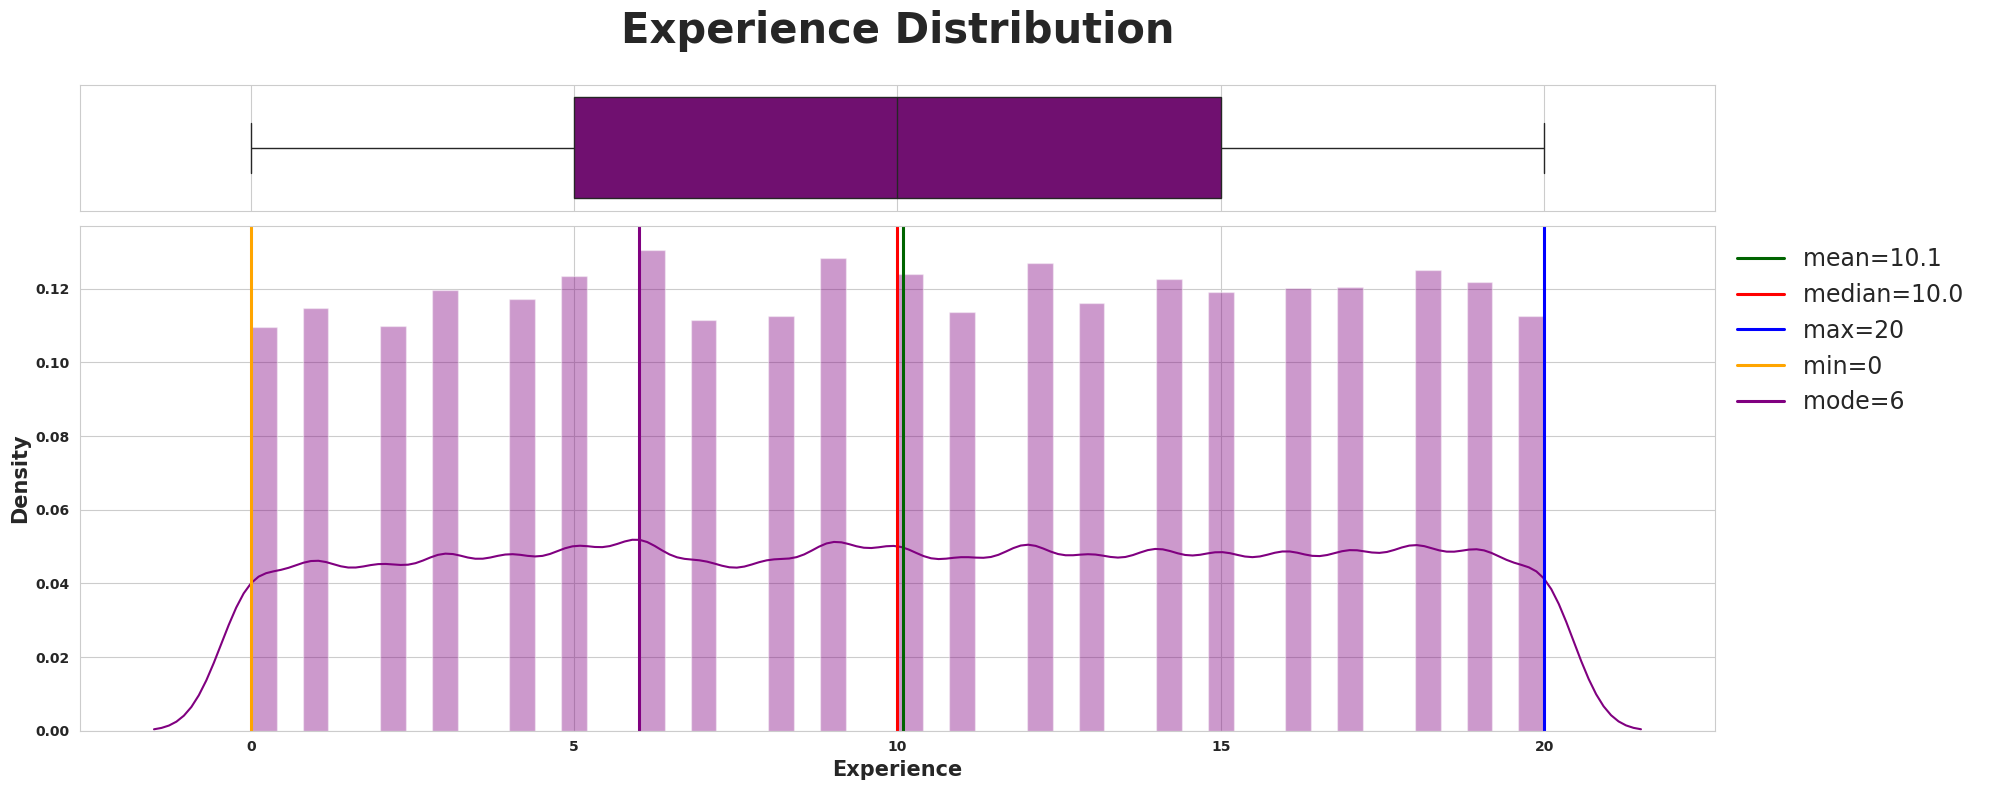

In [94]:
numerical_plotting(data=df, col="Experience",
                   title="Experience Distribution",
                   symb=" ", ylabel="Density", color="purple");

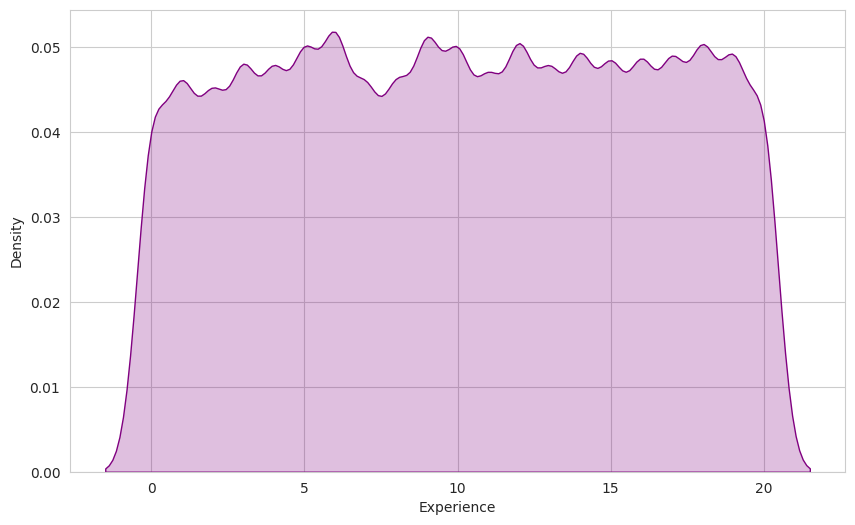

In [95]:
sns.kdeplot(df.Experience, color='purple',shade=True);

In [96]:
experience_count = df["Experience"].value_counts()
print(experience_count)

Experience
6     13158
9     12936
12    12800
18    12601
10    12503
5     12441
14    12369
19    12287
17    12131
16    12106
3     12069
15    11993
4     11807
13    11713
1     11575
11    11449
8     11350
20    11350
7     11232
2     11087
0     11043
Name: count, dtype: int64


In [97]:
df.groupby('Experience').Risk_Flag.apply(lambda x: x.sum()/x.size * 100).sort_values(ascending=False).to_frame().T
# the average risk percentage according to the Experience status

Experience,2,1,15,0,11,16,3,5,7,4,13,6,8,17,20,9,12,19,10,14,18
Risk_Flag,17.047,15.568,15.075,14.326,13.835,13.217,13.141,12.579,12.491,12.272,12.217,11.833,11.753,11.582,11.313,11.279,10.906,10.621,10.517,9.799,8.166


In [98]:
experience_bins = pd.cut(df['Experience'],
                         bins=[0, 5, 15, df['Experience'].max()],
                         labels=[0, 1, 2])  # Junior=0, Mid-level=1, Senior=2

df['Experience_Category_encoded'] = experience_bins.astype("float")
print("Categorized Experience grouped by risk flag indication:\n")
df.groupby('Experience_Category_encoded').Risk_Flag.apply(lambda x: x.sum()/x.size * 100).sort_values(ascending=False).to_frame().T

Categorized Experience grouped by risk flag indication:



Experience_Category_encoded,0.000,1.000,2.000
Risk_Flag,14.059,11.933,10.952


As experience increases, default risk decreases.

###Married / single

In [99]:
# Renaming column to avoid trouble
df.rename(columns={"Married/Single":"Married_Single"}, inplace=True)
df.head(5)
print("\nMarital status ( Count and Percentage):\n ")
# Marital status ( Count and Percentage)
marital_stat_c = df["Married_Single"].value_counts()
marital_stat_p = (marital_stat_c /len(df)) * 100
marital_stat = pd.concat([marital_stat_c, marital_stat_p], axis=1)
marital_stat.columns = ["Count", "Percentage"]
marital_stat

,Income,Age,Experience,Married_Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag,Experience_Category_encoded
0,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0,0.000
1,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0,1.000
2,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0,0.000
3,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1,0.000
4,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1,1.000



Marital status ( Count and Percentage):
 


,Count,Percentage
Married_Single,,
single,226272,89.790
married,25728,10.210


Grouping Marital status by Risk flag can give us insightful outcome.

In [100]:
# Group by 'Married_Single' and 'Risk_Flag' and count the occurrences
marital_risk_counts = df.groupby(['Married_Single', 'Risk_Flag']).size().unstack(fill_value=0).sort_values(by=1, ascending=False)

# the average risk percentage according to the marital status
marital_risk_percentages = df.groupby('Married_Single').Risk_Flag.apply(lambda x: x.sum()/x.size * 100).sort_values(ascending=False).to_frame().T

# If Risk_Flag 0 means No Risk and 1 means Risk:
marital_risk_counts.columns = ['No_Risk', 'Risk']

# Display the resulting table
marital_risk_counts
print("\nRisk_Flag:\n")
marital_risk_percentages


,No_Risk,Risk
Married_Single,,
single,197912,28360
married,23092,2636



Risk_Flag:



Married_Single,single,married
Risk_Flag,12.534,10.246


Text(0.5, 1.0, 'Distribution of the target variable according to maritial status')

[Text(0, 0, '197912'), Text(0, 0, '23092')]

[Text(0, 0, '28360'), Text(0, 0, '2636')]

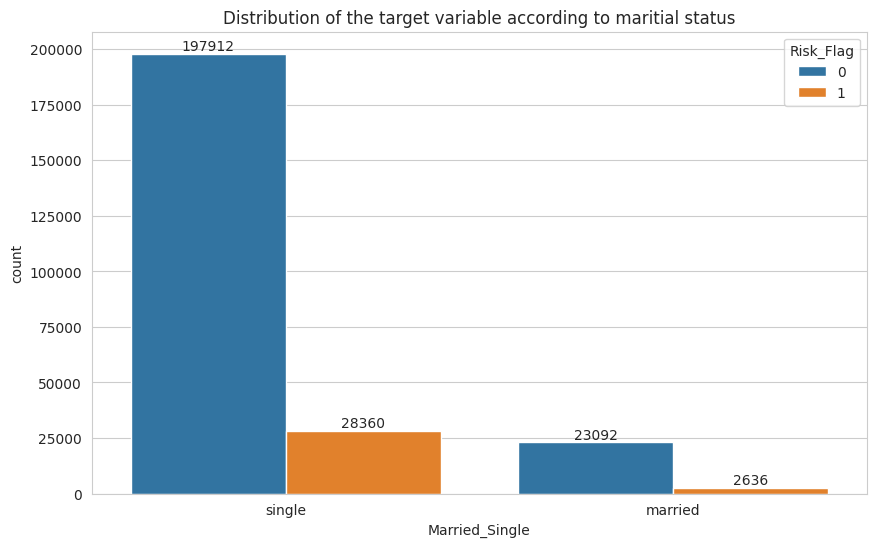

In [101]:
ax = sns.countplot(data = df , x=df["Married_Single"], hue= "Risk_Flag")
plt.title('Distribution of the target variable according to maritial status')
for p in ax.containers:
    ax.bar_label(p)

###House Ownership

In [102]:
House_ownership_count = df["House_Ownership"].value_counts()
print(House_ownership_count)

House_Ownership
rented          231898
owned            12918
norent_noown      7184
Name: count, dtype: int64


In [103]:
df_nohouse_prof = df[df["House_Ownership"] == "norent_noown"]["Profession"].value_counts()
print(df_nohouse_prof)

Profession
Software_Developer     329
Surveyor               319
Biomedical_Engineer    248
Scientist              244
Web_designer           241
                      ... 
Secretary               56
Lawyer                  54
Technical_writer        50
Psychologist            41
Official                26
Name: count, Length: 51, dtype: int64


In [104]:
print("relationship between years a person employes in their current job and their house ownership status:\n")
df_JOB_YRS_house = pd.crosstab([df.CURRENT_JOB_YRS], df.House_Ownership)
print(df_JOB_YRS_house)

relationship between years a person employes in their current job and their house ownership status:

House_Ownership  norent_noown  owned  rented
CURRENT_JOB_YRS                             
0                         489    386   10168
1                         155    394   11026
2                         425    619   10043
3                         563   2081   26816
4                         774   1716   25849
5                         925   1022   23144
6                         715   1152   21624
7                         491    673   18761
8                         449    837   17588
9                         442    644   16046
10                        398    931   14439
11                        561    917   12117
12                        109    650    9846
13                        288    383    8428
14                        400    513    6003


In [105]:
df.groupby('House_Ownership').Risk_Flag.apply(lambda x: x.sum()/x.size * 100).sort_values(ascending=False).to_frame().T
# the average risk percentage according to the house ownership status

House_Ownership,rented,norent_noown,owned
Risk_Flag,12.558,9.953,8.980


###Car Ownership

In [106]:
print("Car ownership status:\n")
df_Car = df["Car_Ownership"].value_counts()
print(df_Car)

print("\nThe average risk percentage according to the car ownership status:\n")
Car_Own_risk = df.groupby('Car_Ownership').Risk_Flag.apply(lambda x: x.sum()/x.size * 100).sort_values(ascending=False).to_frame().T
Car_Own_risk
# the average risk percentage according to the car ownership status

Car ownership status:

Car_Ownership
no     176000
yes     76000
Name: count, dtype: int64

The average risk percentage according to the car ownership status:



Car_Ownership,no,yes
Risk_Flag,12.819,11.099


Relation between car ownership and risk flag indicates there is more people with no car and they are also have high rate of loan default risk than whome has car.

###Profession

In [107]:
print("Number of person working in profession:\n")
Profession = df["Profession"].value_counts()
print(Profession)

print("\nThe average risk percentage according to the profession:\n")
df.groupby('Profession').Risk_Flag.apply(lambda x: x.sum()/x.size * 100).sort_values(ascending=False)
# the average risk percentage of each profession

Number of person working in profession:

Profession
Physician                     5957
Statistician                  5806
Web_designer                  5397
Psychologist                  5390
Computer_hardware_engineer    5372
                              ... 
Firefighter                   4507
Chartered_Accountant          4493
Civil_servant                 4413
Official                      4087
Engineer                      4048
Name: count, Length: 51, dtype: int64

The average risk percentage according to the profession:



,Risk_Flag
Profession,
Police_officer,16.405
Chartered_Accountant,15.357
Army_officer,15.211
Surveyor,15.146
Software_Developer,14.843
...,...
Financial_Analyst,10.315
Economist,9.928
Industrial_Engineer,9.867


###CITY

In [108]:
df["CITY"].value_counts()
df.groupby('CITY').Risk_Flag.apply(lambda x: x.sum()/x.size * 100).sort_values(ascending=False).head(50).to_frame().T


,count
CITY,
Vijayanagaram,1259
Bhopal,1208
Bulandshahr,1185
Saharsa[29],1180
Vijayawada,1172
...,...
Ujjain,486
Warangal[11][12],459
Bettiah[33],457


CITY,Bhubaneswar,Gwalior,Bettiah[33],Kochi,Raiganj,Purnia[26],Barasat,Sikar,Buxar[37],Satna,Kottayam,Kavali,Mysore[7][8][9],Bardhaman,Gandhidham,Imphal,Ghaziabad,Ramagundam[27],Muzaffarnagar,Ahmedabad,Munger,Mathura,Thiruvananthapuram,Hazaribagh,Guntur[13],Mango,Udaipur,Ratlam,Moradabad,Shahjahanpur,Sri_Ganganagar,Srinagar,Indore,Davanagere,North_Dumdum,Tinsukia,Varanasi,Bhind,Bidhannagar,Panipat,Kamarhati,Haldia,Nagpur,Ujjain,Nizamabad,Gaya,Chandrapur,Bhusawal,Gorakhpur,Nangloi_Jat
Risk_Flag,32.619,27.273,26.696,25.286,23.955,23.887,23.870,23.845,23.147,22.568,22.537,22.506,22.057,21.916,21.647,21.555,20.873,20.845,20.808,20.493,20.465,20.334,20.333,20.209,19.875,19.685,19.307,19.196,19.176,19.135,19.094,19.014,18.761,18.465,18.359,18.295,18.100,17.872,17.812,17.705,17.677,17.629,17.373,17.284,17.273,17.226,17.034,16.997,16.995,16.939


In [109]:
df.groupby(['STATE', "CITY"]).Risk_Flag.apply(lambda x: x.sum()/x.size * 100).sort_values(ascending=False)


STATE           CITY            
Odisha          Bhubaneswar        32.619
Madhya_Pradesh  Gwalior            27.273
Bihar           Bettiah[33]        26.696
Kerala          Kochi              25.286
West_Bengal     Raiganj            23.955
                                    ...  
Karnataka       Bangalore           3.714
                Bijapur             3.497
Delhi           Sultan_Pur_Majra    3.409
Uttarakhand     Dehradun            2.635
Gujarat         Gandhinagar         2.611
Name: Risk_Flag, Length: 317, dtype: float64

###STATE

In [110]:
df["STATE"].value_counts()


,count
STATE,
Uttar_Pradesh,28400
Maharashtra,25562
Andhra_Pradesh,25297
West_Bengal,23483
Bihar,19780
...,...
Himachal_Pradesh,833
Tripura,809
Uttar_Pradesh[5],743


The third row from the bottom caught my attention. There is a specific state called "Uttar Pradesh," and it is also listed as "Uttar Pradesh[5]." We need to merge these two entries together.
Additionally, we should look for similarities in other states to improve the dataset.

In [111]:
print("Unique values in 'STATE' column:")
print(df['STATE'].unique())

Unique values in 'STATE' column:
['Madhya_Pradesh' 'Maharashtra' 'Kerala' 'Odisha' 'Tamil_Nadu' 'Gujarat'
 'Rajasthan' 'Telangana' 'Bihar' 'Andhra_Pradesh' 'West_Bengal' 'Haryana'
 'Puducherry' 'Karnataka' 'Uttar_Pradesh' 'Himachal_Pradesh' 'Punjab'
 'Tripura' 'Uttarakhand' 'Jharkhand' 'Mizoram' 'Assam' 'Jammu_and_Kashmir'
 'Delhi' 'Chhattisgarh' 'Chandigarh' 'Uttar_Pradesh[5]' 'Manipur' 'Sikkim']


There is no other similarity. Using lambda function to modify STATE column.

In [112]:
df["STATE"] = df["STATE"].apply(lambda x: "Uttar_Pradesh" if x == "Uttar_Pradesh[5]" else x)
df["STATE"].value_counts()

,count
STATE,
Uttar_Pradesh,29143
Maharashtra,25562
Andhra_Pradesh,25297
West_Bengal,23483
Bihar,19780
...,...
Manipur,849
Himachal_Pradesh,833
Tripura,809


In [113]:
print("The average risk percentage according to the state:\n")
df.groupby('STATE').Risk_Flag.apply(lambda x: x.sum()/x.size * 100).sort_values(ascending=False).to_frame().T
# the average risk percentage of each state

The average risk percentage according to the state:



STATE,Manipur,Tripura,Kerala,Jammu_and_Kashmir,Madhya_Pradesh,Odisha,Rajasthan,Jharkhand,Chhattisgarh,Himachal_Pradesh,Assam,Bihar,Telangana,West_Bengal,Haryana,Uttar_Pradesh,Gujarat,Puducherry,Andhra_Pradesh,Maharashtra,Mizoram,Delhi,Tamil_Nadu,Karnataka,Chandigarh,Punjab,Uttarakhand,Sikkim
Risk_Flag,21.555,16.811,16.710,15.899,15.437,14.255,14.083,13.330,13.328,13.325,13.169,13.059,13.012,12.814,12.421,11.804,11.772,11.654,11.602,11.325,11.072,10.455,10.316,10.030,9.299,9.004,7.097,4.605


###CURRENT JOB YEARS

In [114]:
print("Number of person working in same current job years in :\n")
df["CURRENT_JOB_YRS"].value_counts()

print("\nThe average risk percentage according to the current job years:\n")
df.groupby('CURRENT_JOB_YRS').Risk_Flag.apply(lambda x: x.sum()/x.size * 100).sort_values(ascending=False).to_frame().T
# the average risk percentage according to the current job years


Number of person working in same current job years in :



,count
CURRENT_JOB_YRS,
3,29460
4,28339
5,25091
6,23491
7,19925
8,18874
9,17132
10,15768
11,13595



The average risk percentage according to the current job years:



CURRENT_JOB_YRS,2,1,0,13,11,6,10,5,14,7,3,8,4,9,12
Risk_Flag,17.047,15.568,14.326,13.969,13.255,12.217,11.923,11.845,11.813,11.769,11.578,11.556,11.317,10.799,10.523


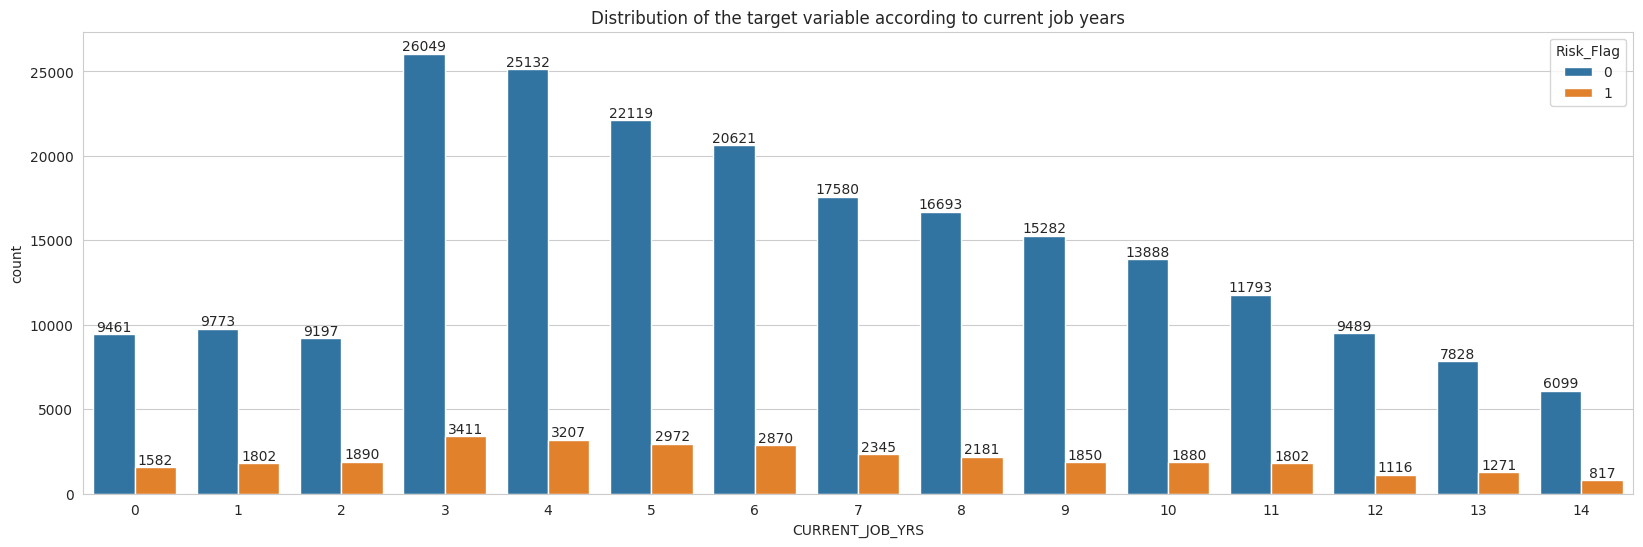

In [115]:
plt.figure(figsize=(20,6));
ax = sns.countplot(data = df , x=df["CURRENT_JOB_YRS"].sort_values(), hue= "Risk_Flag");
plt.title('Distribution of the target variable according to current job years');
for bars in ax.containers:
        ax.bar_label(bars);
plt.show();

###Risk Flag

In [116]:
## Analyzing the Distribution of the Target Variable with Percentages

print("Risk Flag Distribution (Count and Percentage):\n")

# Get the value counts
risk_flag_counts = df["Risk_Flag"].value_counts()

# Calculate the percentages
risk_flag_percentages = df["Risk_Flag"].value_counts(normalize=True) * 100

# Combine counts and percentages into a single table
risk_flag_distribution = pd.concat([risk_flag_counts, risk_flag_percentages], axis=1)

# Rename the columns for clarity
risk_flag_distribution.columns = ["Count", "Percentage"]

# Display the table
print(risk_flag_distribution)

Risk Flag Distribution (Count and Percentage):

            Count  Percentage
Risk_Flag                    
0          221004      87.700
1           30996      12.300


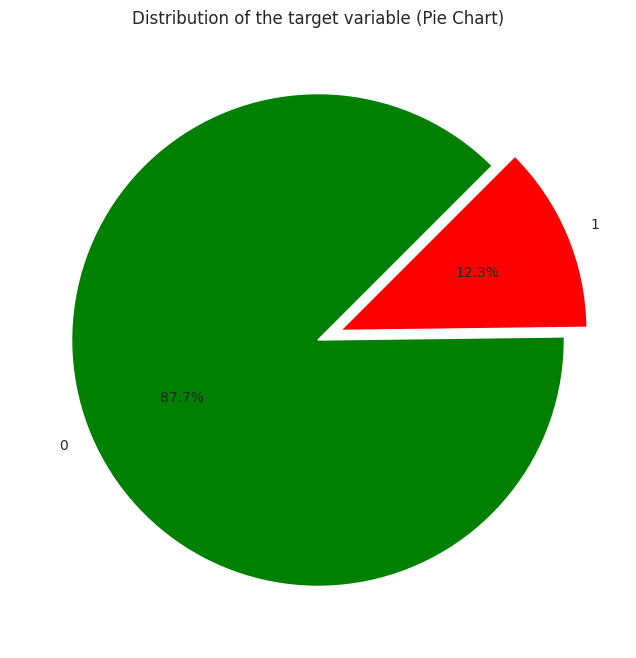

In [117]:
## Plotting the Pie Chart for Risk Flag Distribution

# Create a new figure for the pie chart
plt.figure(figsize=(8,8)); # A square figure is often better for pie charts

# Generate the pie chart
plt.pie(df.Risk_Flag.value_counts(), labels = df.Risk_Flag.value_counts().index, autopct = '%1.1f%%', startangle = 45, explode = (0, 0.1), colors = ['green', 'red'] );
plt.title('Distribution of the target variable (Pie Chart)'); # Title for the pie chart

# Display this figure
plt.show();

There is a significant difference between Risk and No Risk values, indicating that we are dealing with an imbalanced dataset, which is common in business analysis.

In [118]:
# Select only numerical columns for correlation calculation
df_numeric = df.select_dtypes(include=np.number)

# Calculate the correlation with the target variable
correlation_with_risk_flag = df_numeric.corr()['Risk_Flag'].drop('Risk_Flag')

# Display the correlation values with styling
print("Correlation with Risk_Flag (Styled Table):")

# Apply styling to highlight values
# Use background_gradient to color cells based on their value

styled_correlation = correlation_with_risk_flag.sort_values(ascending=False).to_frame().style.background_gradient(cmap='coolwarm')

# Display the styled output
display(styled_correlation)

Correlation with Risk_Flag (Styled Table):


,Risk_Flag
Income,-0.003091
CURRENT_HOUSE_YRS,-0.004375
CURRENT_JOB_YRS,-0.016942
Age,-0.021809
Experience_Category_encoded,-0.033340
Experience,-0.034523


The table shows the correlation between numerical features and the target variable Risk_Flag. All values are negative, indicating a slight inverse relationship — as these feature values increase, the likelihood of loan default slightly decreases. However, the correlations are weak, suggesting that default risk is influenced by more complex, non-linear patterns across multiple variables. (As shown in heatmap earlier)

#Developing Model

###Loading necessary libraries


In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                           roc_curve, precision_recall_curve, f1_score, accuracy_score)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

##Data Preprocessing

In [120]:
def preprocess_data(df):
    """
    Preprocess the loan dataset for modeling
    """
    # Create a copy to avoid modifying original data
    data = df.copy()

    # Encode categorical variables
    le = LabelEncoder()
    categorical_columns = ['Married_Single', 'House_Ownership', 'Car_Ownership',
                          'Profession', 'CITY', 'STATE']

    for col in categorical_columns:
        data[col + '_encoded'] = le.fit_transform(data[col])

    # Feature Engineering - Create additional meaningful features
    data['Income_to_Age_ratio'] = data['Income'] / (data['Age'] + 1)  # +1 to avoid division by zero
    data['Experience_to_Age_ratio'] = data['Experience'] / (data['Age'] + 1)
    data['Job_Stability'] = data['CURRENT_JOB_YRS'] / (data['Experience'] + 1)
    data['Residence_Stability'] = data['CURRENT_HOUSE_YRS'] / (data['Age'] + 1)

    # Create income categories
    data['Income_Category'] = pd.cut(data['Income'],
                                   bins=[0, data['Income'].quantile(0.33),
                                        data['Income'].quantile(0.67), data['Income'].max()],
                                   labels=['Low', 'Medium', 'High'])
    data['Income_Category_encoded'] = le.fit_transform(data['Income_Category'])

    # Create experience categories
    data['Experience_Category'] = pd.cut(data['Experience'],
                                       bins=[0, 5, 15, data['Experience'].max()],
                                       labels=['Junior', 'Mid_level', 'Senior'])
    data['Experience_Category_encoded'] = le.fit_transform(data['Experience_Category'])

    return data


In [121]:
# Preprocess the data
processed_df = preprocess_data(df)

# =============================================================================
#  PREPARE FEATURES AND TARGET
# =============================================================================

# Select features for modeling
feature_columns = ['Income', 'Age', 'Experience', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS',
                  'Married_Single_encoded', 'House_Ownership_encoded', 'Car_Ownership_encoded',
                  'Profession_encoded', 'CITY_encoded', 'STATE_encoded',
                  'Income_to_Age_ratio', 'Experience_to_Age_ratio', 'Job_Stability',
                  'Residence_Stability', 'Income_Category_encoded', 'Experience_Category_encoded']

X = processed_df[feature_columns]
y = processed_df['Risk_Flag']

# Scale numerical features
scaler = StandardScaler()
numerical_features = ['Income', 'Age', 'Experience', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS',
                     'Income_to_Age_ratio', 'Experience_to_Age_ratio', 'Job_Stability',
                     'Residence_Stability']

X_scaled = X.copy()
X_scaled[numerical_features] = scaler.fit_transform(X[numerical_features])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2,
                                                    random_state=42, stratify=y)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Class distribution in training set:")
print(y_train.value_counts(normalize=True))


Training set shape: (201600, 17)
Test set shape: (50400, 17)
Class distribution in training set:
Risk_Flag
0   0.877
1   0.123
Name: proportion, dtype: float64


In [122]:
pip install hmeasure


In [123]:
import hmeasure

In [124]:
# =============================================================================
# HELPER FUNCTIONS FOR EVALUATION
# =============================================================================

def plot_roc_curve(y_true, y_pred_proba, model_name):
    """Plot ROC curve"""
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    auc_score = roc_auc_score(y_true, y_pred_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.4f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

    return auc_score

def plot_lift_curve(y_true, y_pred_proba, model_name):
    """Plot Lift Curve"""
    # Create a dataframe with actual and predicted values
    df_lift = pd.DataFrame({
        'actual': y_true,
        'predicted_proba': y_pred_proba
    })

    # Sort by predicted probability in descending order
    df_lift = df_lift.sort_values('predicted_proba', ascending=False).reset_index(drop=True)

    # Create deciles
    df_lift['decile'] = pd.cut(range(len(df_lift)), bins=10, labels=range(1, 11))

    # Calculate lift for each decile
    lift_table = df_lift.groupby('decile').agg({
        'actual': ['count', 'sum']
    }).round(2)

    lift_table.columns = ['total_customers', 'total_defaults']
    lift_table['default_rate'] = lift_table['total_defaults'] / lift_table['total_customers']
    lift_table['cumulative_defaults'] = lift_table['total_defaults'].cumsum()
    lift_table['cumulative_customers'] = lift_table['total_customers'].cumsum()
    lift_table['cumulative_default_rate'] = lift_table['cumulative_defaults'] / lift_table['cumulative_customers']

    # Overall default rate
    overall_default_rate = y_true.mean()
    lift_table['lift'] = lift_table['default_rate'] / overall_default_rate
    lift_table['cumulative_lift'] = lift_table['cumulative_default_rate'] / overall_default_rate

    # Plot lift curve
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.bar(range(1, 11), lift_table['lift'], alpha=0.7)
    plt.axhline(y=1, color='red', linestyle='--', label='Baseline')
    plt.xlabel('Decile')
    plt.ylabel('Lift')
    plt.title(f'Lift by Decile - {model_name}')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(range(1, 11), lift_table['cumulative_lift'], marker='o', linewidth=2)
    plt.axhline(y=1, color='red', linestyle='--', label='Baseline')
    plt.xlabel('Decile')
    plt.ylabel('Cumulative Lift')
    plt.title(f'Cumulative Lift - {model_name}')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return lift_table

def calculate_h_measure(y_true, y_pred_proba):
    """Calculate H-measure (alternative to AUC)"""
    # Note: Convert y_true to a NumPy array
    from hmeasure import h_score
    h = h_score(y_true.values, y_pred_proba)

    """
    The H-measure evaluates how well a classifier distinguishes between
         classes while incorporating a realistic cost model for misclassifications.

    """
    #print("H-measure:", h)


    return h

def evaluate_model(model, X_test, y_test, model_name):
    """Comprehensive model evaluation"""
    print(f"\n{'='*50}")
    print(f"EVALUATION RESULTS - {model_name}")
    print(f"{'='*50}")

    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Basic metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)
    h_measure = calculate_h_measure(y_test, y_pred_proba)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC Score: {auc_score:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"H-Measure: {h_measure:.4f}")

    # Classification report
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # ROC Curve
    auc_score = plot_roc_curve(y_test, y_pred_proba, model_name)

    # Lift Curve
    lift_table = plot_lift_curve(y_test, y_pred_proba, model_name)

    return {
        'accuracy': accuracy,
        'auc_score': auc_score,
        'f1_score': f1,
        'h_measure': h_measure,
        'lift_table': lift_table
    }


TRAINING LOGISTIC REGRESSION ON IMBALANCED DATA


LogisticRegression(max_iter=1000, random_state=42)


EVALUATION RESULTS - Logistic Regression (Imbalanced)
Accuracy: 0.8770
AUC Score: 0.5491
F1 Score: 0.0000
H-Measure: 0.0103

Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93     44201
           1       0.00      0.00      0.00      6199

    accuracy                           0.88     50400
   macro avg       0.44      0.50      0.47     50400
weighted avg       0.77      0.88      0.82     50400



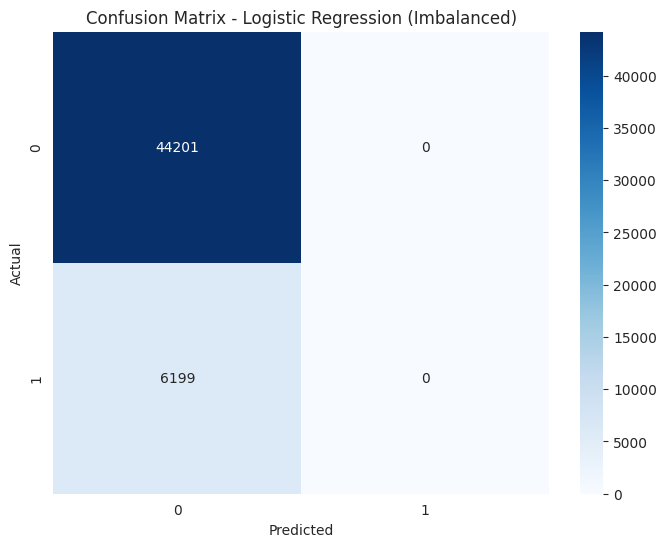

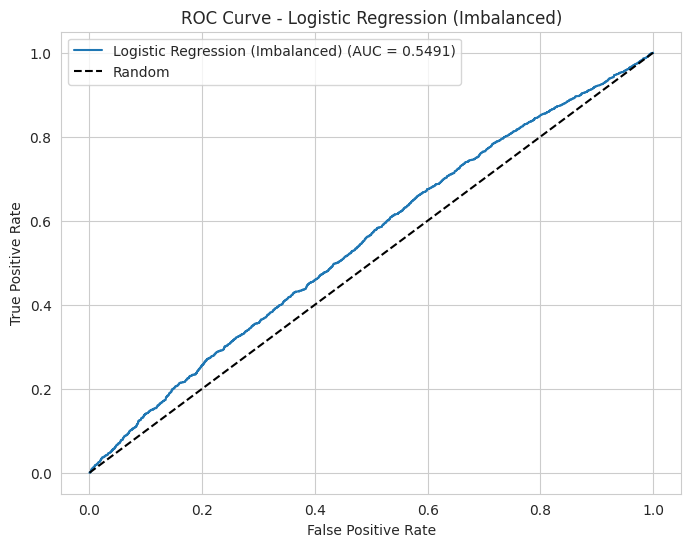

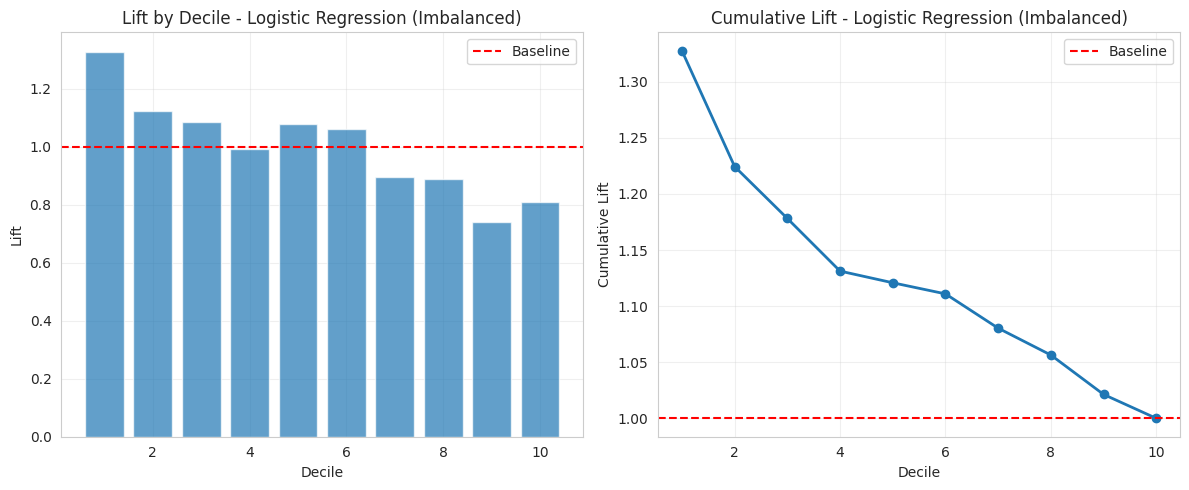

In [125]:
# =============================================================================
#  LOGISTIC REGRESSION ON IMBALANCED DATA
# =============================================================================

print("TRAINING LOGISTIC REGRESSION ON IMBALANCED DATA")
print("="*60)

# Train logistic regression
lr_imbalanced = LogisticRegression(random_state=42, max_iter=1000)
lr_imbalanced.fit(X_train, y_train)

# Evaluate
lr_imbalanced_results = evaluate_model(lr_imbalanced, X_test, y_test,
                                      "Logistic Regression (Imbalanced)")



HANDLING CLASS IMBALANCE
After SMOTE:
Training set shape: (353606, 17)
Class distribution:
Risk_Flag
0   0.500
1   0.500
Name: proportion, dtype: float64

After Undersampling:
Training set shape: (49594, 17)
Class distribution:
Risk_Flag
0   0.500
1   0.500
Name: proportion, dtype: float64

TRAINING LOGISTIC REGRESSION ON BALANCED DATA (SMOTE)


LogisticRegression(max_iter=1000, random_state=42)


EVALUATION RESULTS - Logistic Regression (SMOTE Balanced)
Accuracy: 0.5321
AUC Score: 0.5348
F1 Score: 0.2135
H-Measure: 0.0064

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.53      0.67     44201
           1       0.13      0.52      0.21      6199

    accuracy                           0.53     50400
   macro avg       0.51      0.53      0.44     50400
weighted avg       0.79      0.53      0.61     50400



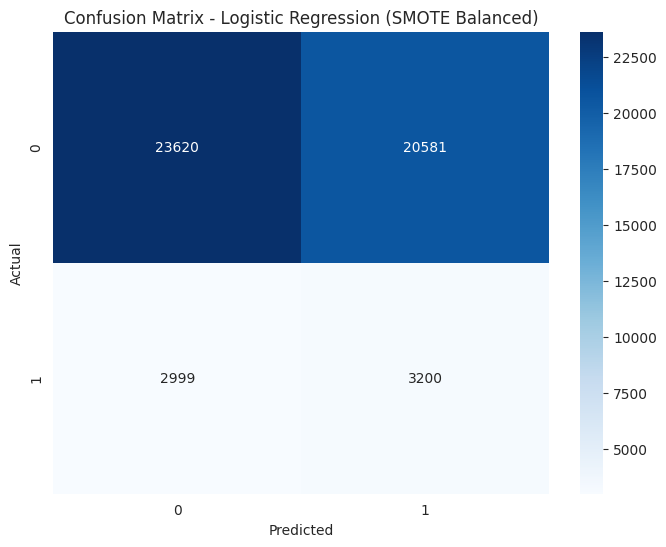

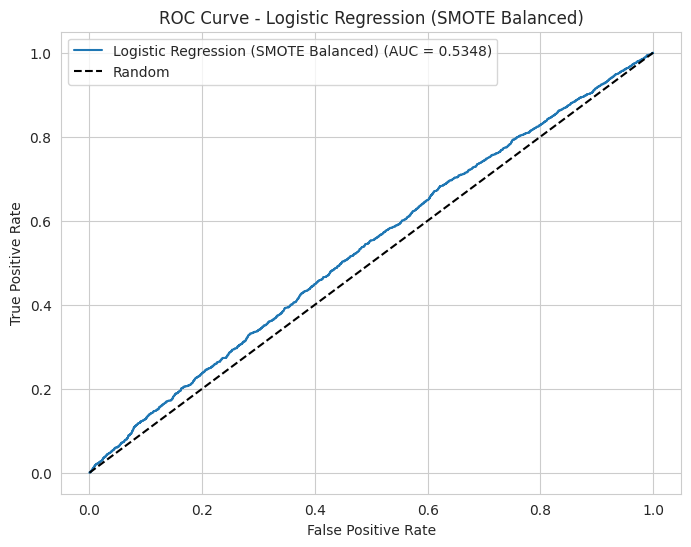

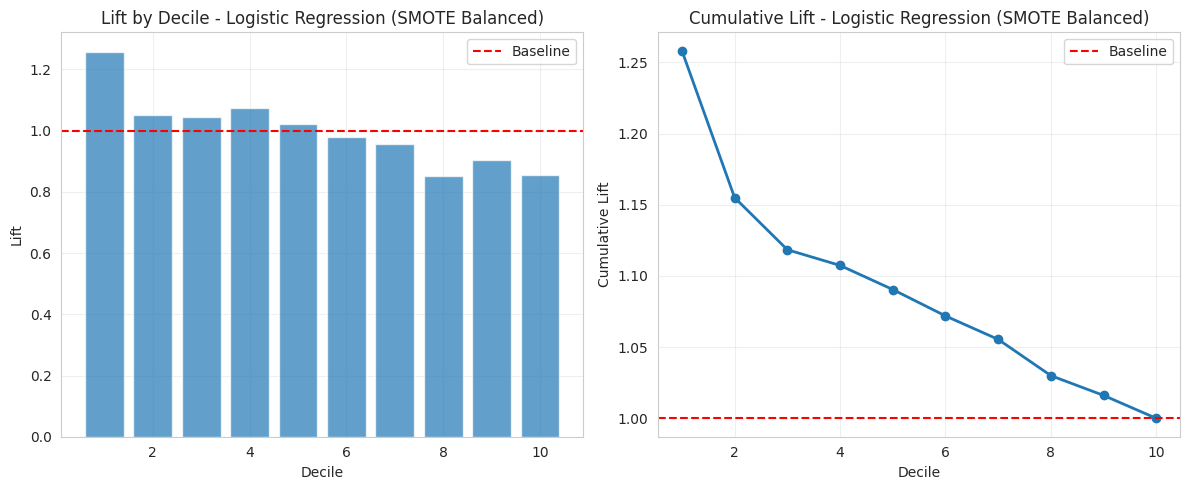


TRAINING LOGISTIC REGRESSION ON UNDERSAMPLED DATA


LogisticRegression(max_iter=1000, random_state=42)


EVALUATION RESULTS - Logistic Regression (Undersampled)
Accuracy: 0.5059
AUC Score: 0.5503
F1 Score: 0.2246
H-Measure: 0.0112

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.50      0.64     44201
           1       0.14      0.58      0.22      6199

    accuracy                           0.51     50400
   macro avg       0.52      0.54      0.43     50400
weighted avg       0.80      0.51      0.59     50400



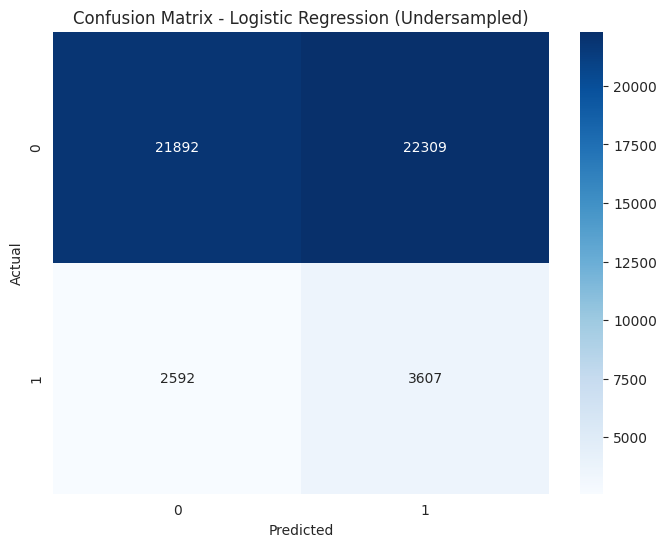

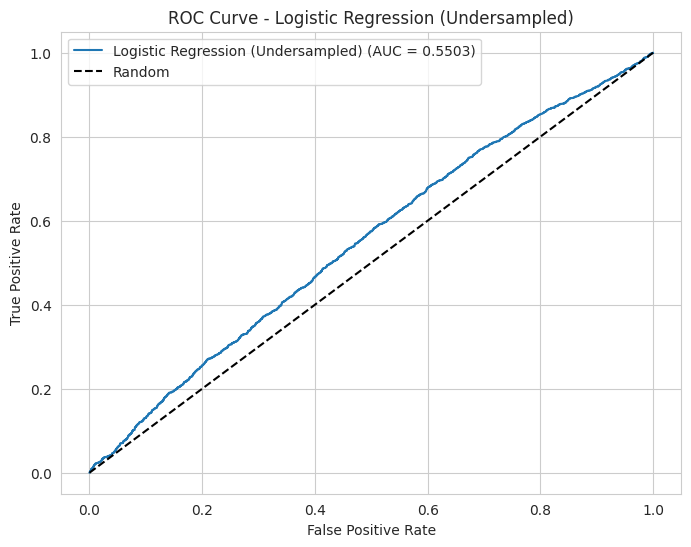

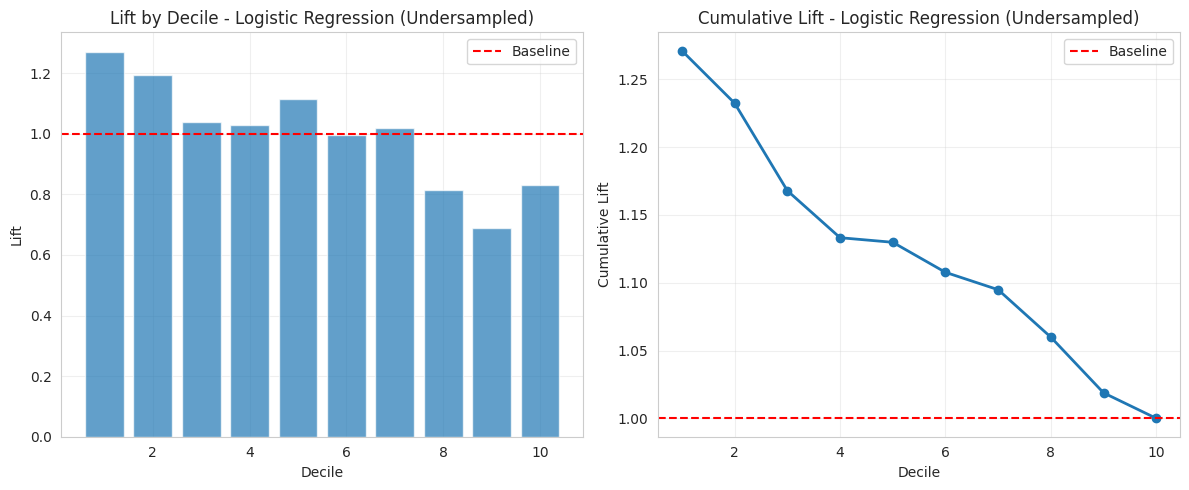

In [126]:
# =============================================================================
#  HANDLE CLASS IMBALANCE AND TRAIN LOGISTIC REGRESSION
# =============================================================================

print("\n\nHANDLING CLASS IMBALANCE")
print("="*60)

# Method 1: SMOTE (Oversampling)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("After SMOTE:")
print(f"Training set shape: {X_train_smote.shape}")
print("Class distribution:")
print(pd.Series(y_train_smote).value_counts(normalize=True))

# Method 2: Random Undersampling
undersampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)

print(f"\nAfter Undersampling:")
print(f"Training set shape: {X_train_under.shape}")
print("Class distribution:")
print(pd.Series(y_train_under).value_counts(normalize=True))

# Train logistic regression on balanced data (SMOTE)
print("\nTRAINING LOGISTIC REGRESSION ON BALANCED DATA (SMOTE)")
print("="*60)

lr_balanced_smote = LogisticRegression(random_state=42, max_iter=1000)
lr_balanced_smote.fit(X_train_smote, y_train_smote)

lr_balanced_smote_results = evaluate_model(lr_balanced_smote, X_test, y_test,
                                          "Logistic Regression (SMOTE Balanced)")

# Train logistic regression on undersampled data
print("\nTRAINING LOGISTIC REGRESSION ON UNDERSAMPLED DATA")
print("="*60)

lr_balanced_under = LogisticRegression(random_state=42, max_iter=1000)
lr_balanced_under.fit(X_train_under, y_train_under)

lr_balanced_under_results = evaluate_model(lr_balanced_under, X_test, y_test,
                                          "Logistic Regression (Undersampled)")



TRAINING RANDOM FOREST ON IMBALANCED DATA


RandomForestClassifier(n_jobs=-1, random_state=42)


EVALUATION RESULTS - Random Forest (Imbalanced)
Accuracy: 0.8971
AUC Score: 0.9363
F1 Score: 0.5618
H-Measure: 0.6271

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94     44201
           1       0.59      0.54      0.56      6199

    accuracy                           0.90     50400
   macro avg       0.76      0.74      0.75     50400
weighted avg       0.89      0.90      0.89     50400



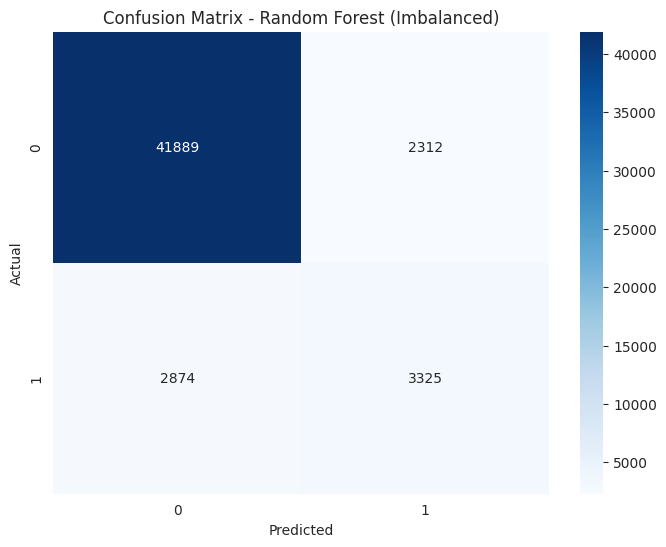

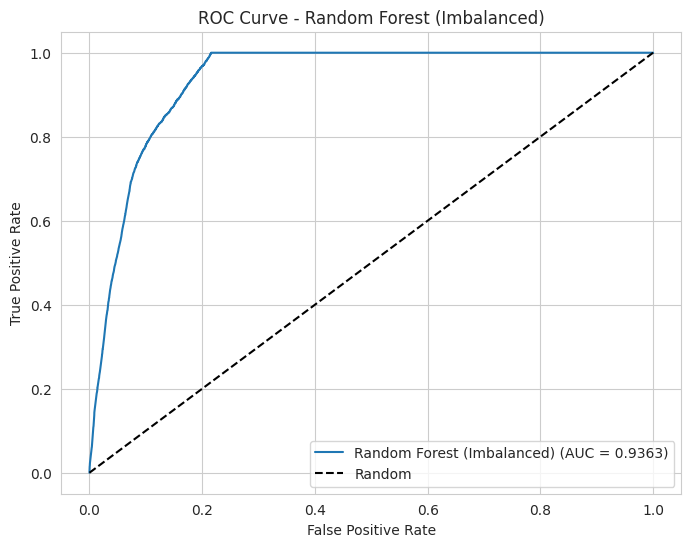

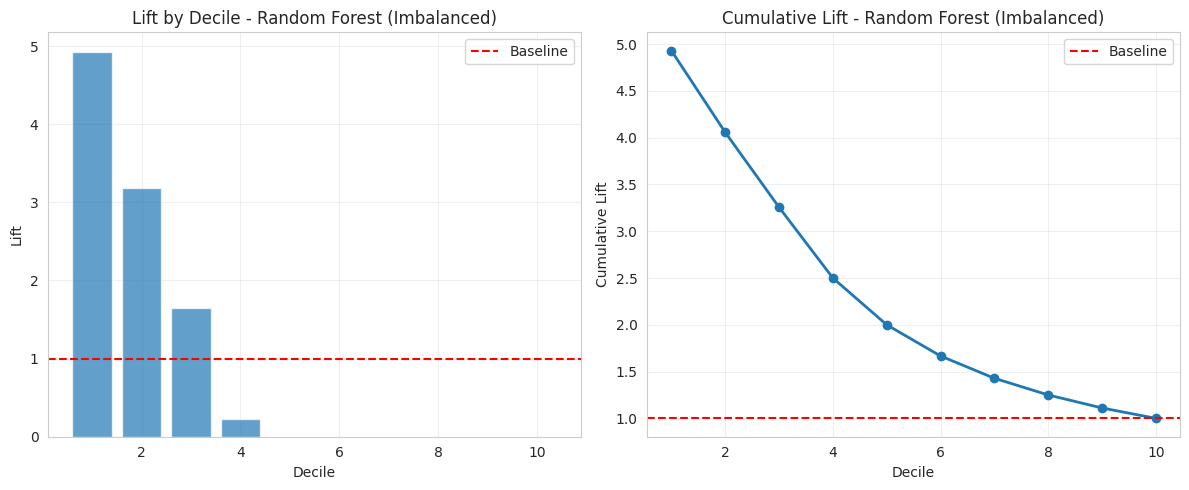

<Figure size 1200x800 with 0 Axes>

<Axes: xlabel='importance', ylabel='feature'>

Text(0.5, 1.0, 'Top 15 Feature Importances - Random Forest (Imbalanced)')

Text(0.5, 0, 'Feature Importance')

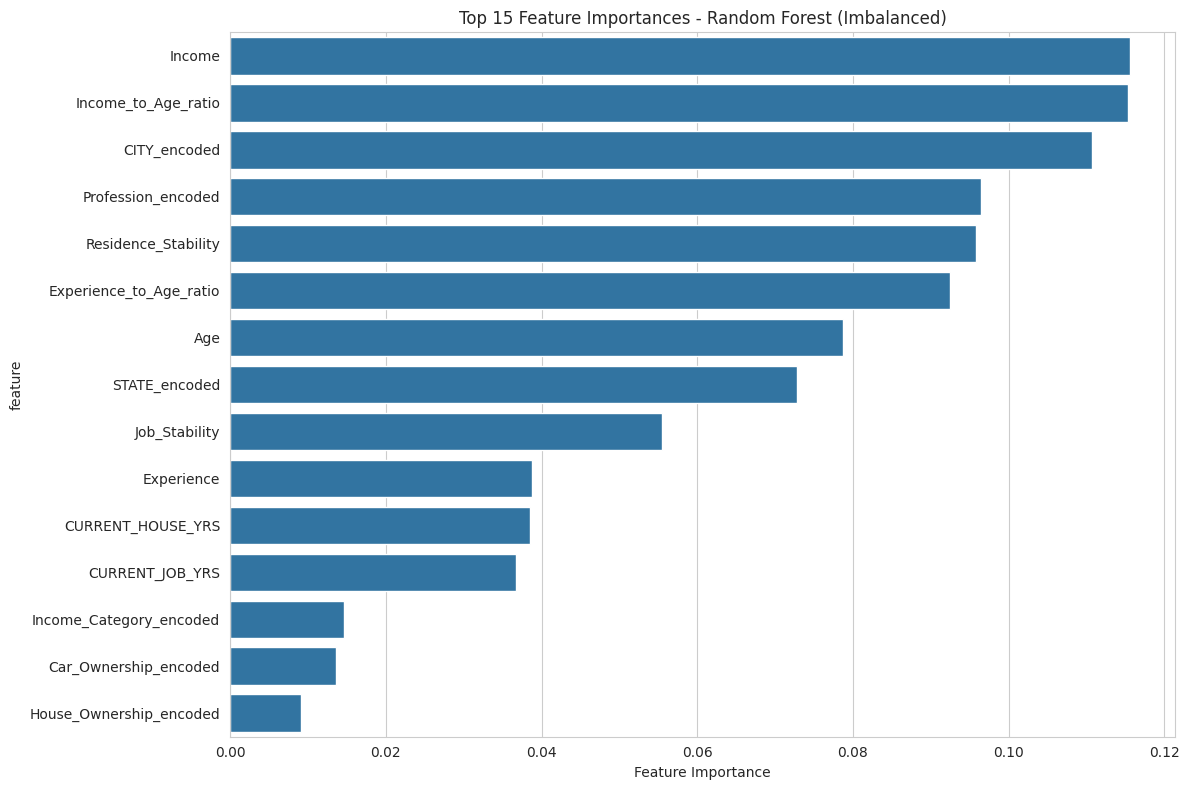


Top 10 Most Important Features:
                    feature  importance
0                    Income       0.116
11      Income_to_Age_ratio       0.115
9              CITY_encoded       0.111
8        Profession_encoded       0.096
14      Residence_Stability       0.096
12  Experience_to_Age_ratio       0.093
1                       Age       0.079
10            STATE_encoded       0.073
13            Job_Stability       0.056
2                Experience       0.039


In [127]:
# =============================================================================
# RANDOM FOREST ON IMBALANCED DATA
# =============================================================================

print("\nTRAINING RANDOM FOREST ON IMBALANCED DATA")
print("="*60)

# Train random forest
rf_imbalanced = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_imbalanced.fit(X_train, y_train)

rf_imbalanced_results = evaluate_model(rf_imbalanced, X_test, y_test,
                                      "Random Forest (Imbalanced)")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_imbalanced.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance.head(15), x='importance', y='feature')
plt.title('Top 15 Feature Importances - Random Forest (Imbalanced)')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))



TRAINING RANDOM FOREST ON BALANCED DATA (SMOTE)


RandomForestClassifier(n_jobs=-1, random_state=42)


EVALUATION RESULTS - Random Forest (SMOTE Balanced)
Accuracy: 0.8893
AUC Score: 0.9362
F1 Score: 0.6320
H-Measure: 0.6312

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.91      0.93     44201
           1       0.53      0.77      0.63      6199

    accuracy                           0.89     50400
   macro avg       0.75      0.84      0.78     50400
weighted avg       0.91      0.89      0.90     50400



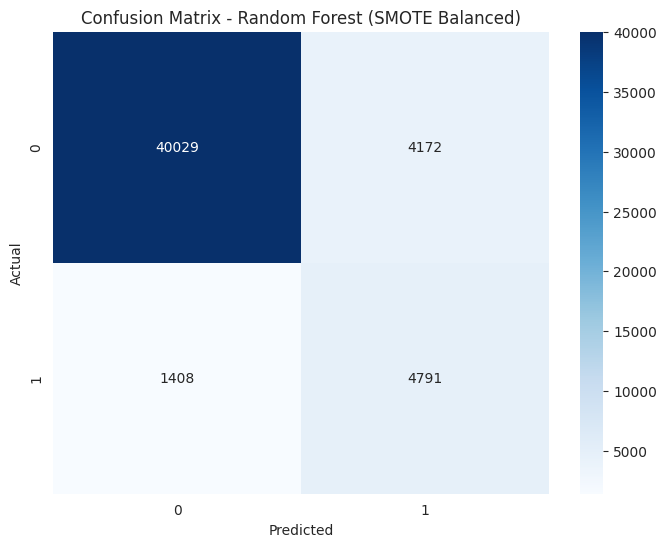

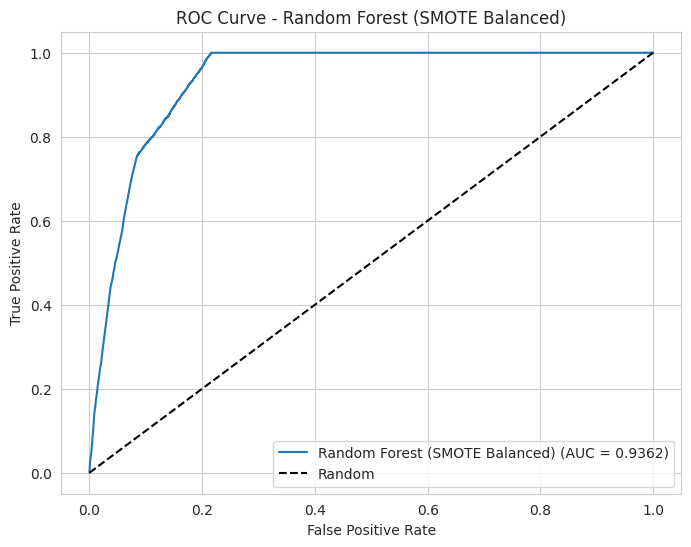

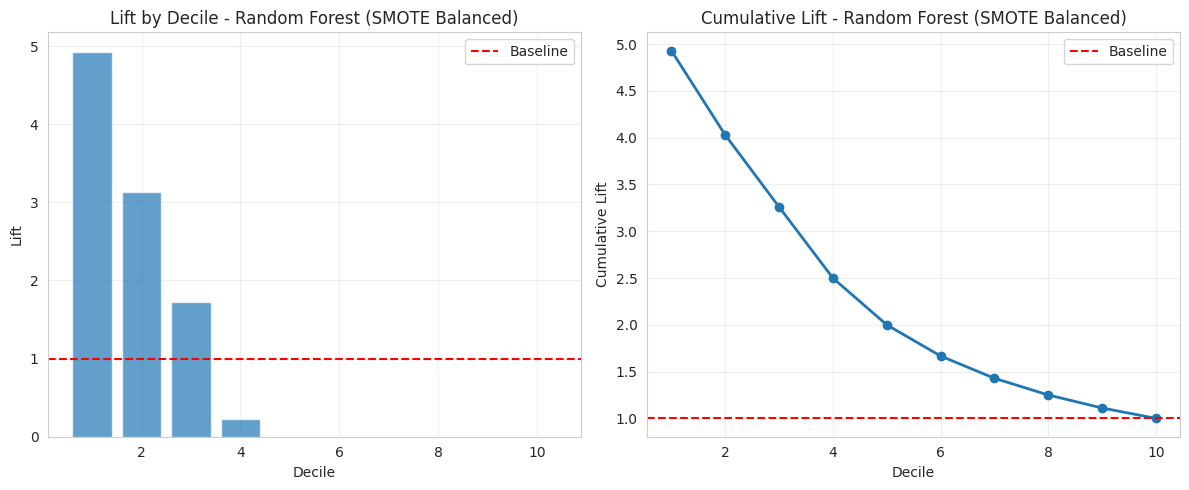


TRAINING RANDOM FOREST ON UNDERSAMPLED DATA


RandomForestClassifier(n_jobs=-1, random_state=42)


EVALUATION RESULTS - Random Forest (Undersampled)
Accuracy: 0.8745
AUC Score: 0.9327
F1 Score: 0.6148
H-Measure: 0.6197

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.88      0.93     44201
           1       0.49      0.81      0.61      6199

    accuracy                           0.87     50400
   macro avg       0.73      0.85      0.77     50400
weighted avg       0.91      0.87      0.89     50400



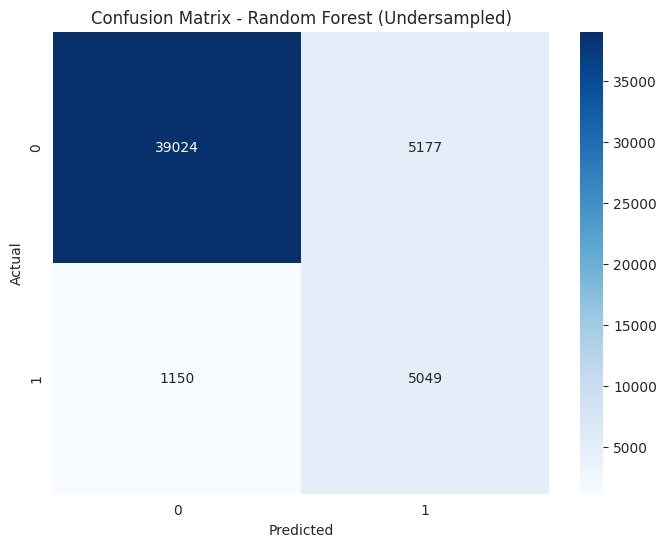

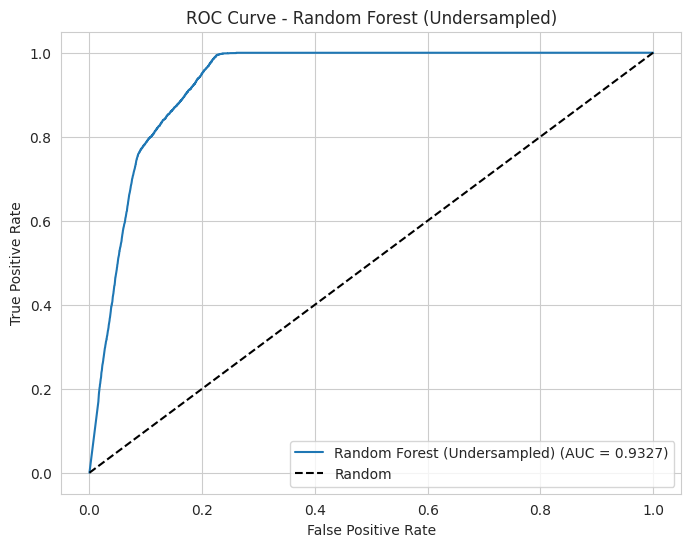

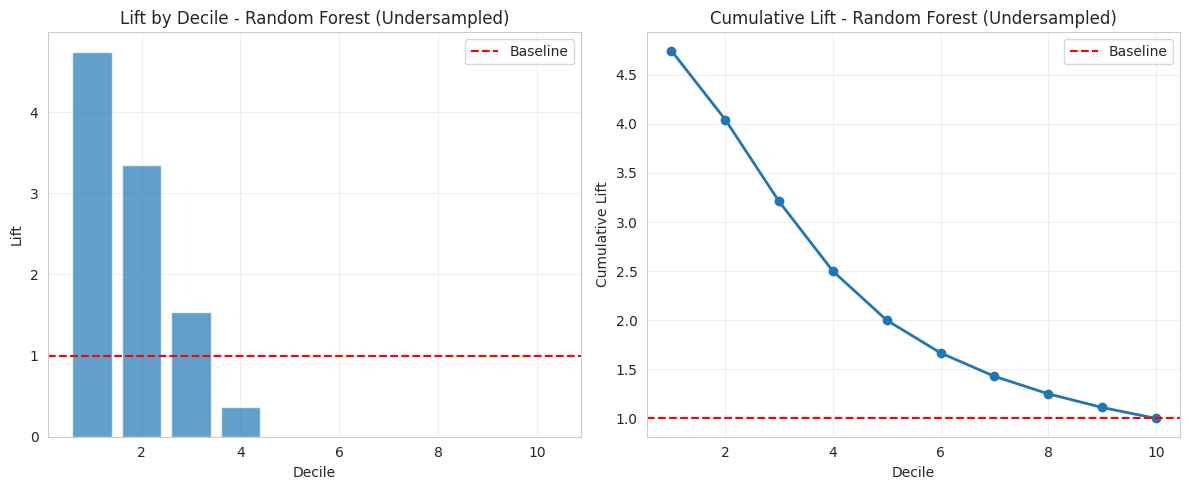

In [128]:
# =============================================================================
# RANDOM FOREST ON BALANCED DATA
# =============================================================================

print("\nTRAINING RANDOM FOREST ON BALANCED DATA (SMOTE)")
print("="*60)

rf_balanced_smote = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_balanced_smote.fit(X_train_smote, y_train_smote)

rf_balanced_smote_results = evaluate_model(rf_balanced_smote, X_test, y_test,
                                          "Random Forest (SMOTE Balanced)")

print("\nTRAINING RANDOM FOREST ON UNDERSAMPLED DATA")
print("="*60)

rf_balanced_under = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_balanced_under.fit(X_train_under, y_train_under)

rf_balanced_under_results = evaluate_model(rf_balanced_under, X_test, y_test,
                                          "Random Forest (Undersampled)")




MODEL COMPARISON SUMMARY
                                    Accuracy  AUC Score  F1 Score  H-Measure
Logistic Regression (Imbalanced)       0.877      0.549     0.000      0.010
Logistic Regression (SMOTE)            0.532      0.535     0.213      0.006
Logistic Regression (Undersampled)     0.506      0.550     0.225      0.011
Random Forest (Imbalanced)             0.897      0.936     0.562      0.627
Random Forest (SMOTE)                  0.889      0.936     0.632      0.631
Random Forest (Undersampled)           0.875      0.933     0.615      0.620


<Axes: >

Text(0.5, 1.0, 'Accuracy Comparison')

Text(0, 0.5, 'Accuracy')

<Axes: >

Text(0.5, 1.0, 'AUC Score Comparison')

Text(0, 0.5, 'AUC Score')

<Axes: >

Text(0.5, 1.0, 'F1 Score Comparison')

Text(0, 0.5, 'F1 Score')

<Axes: >

Text(0.5, 1.0, 'H-Measure Comparison')

Text(0, 0.5, 'H-Measure')

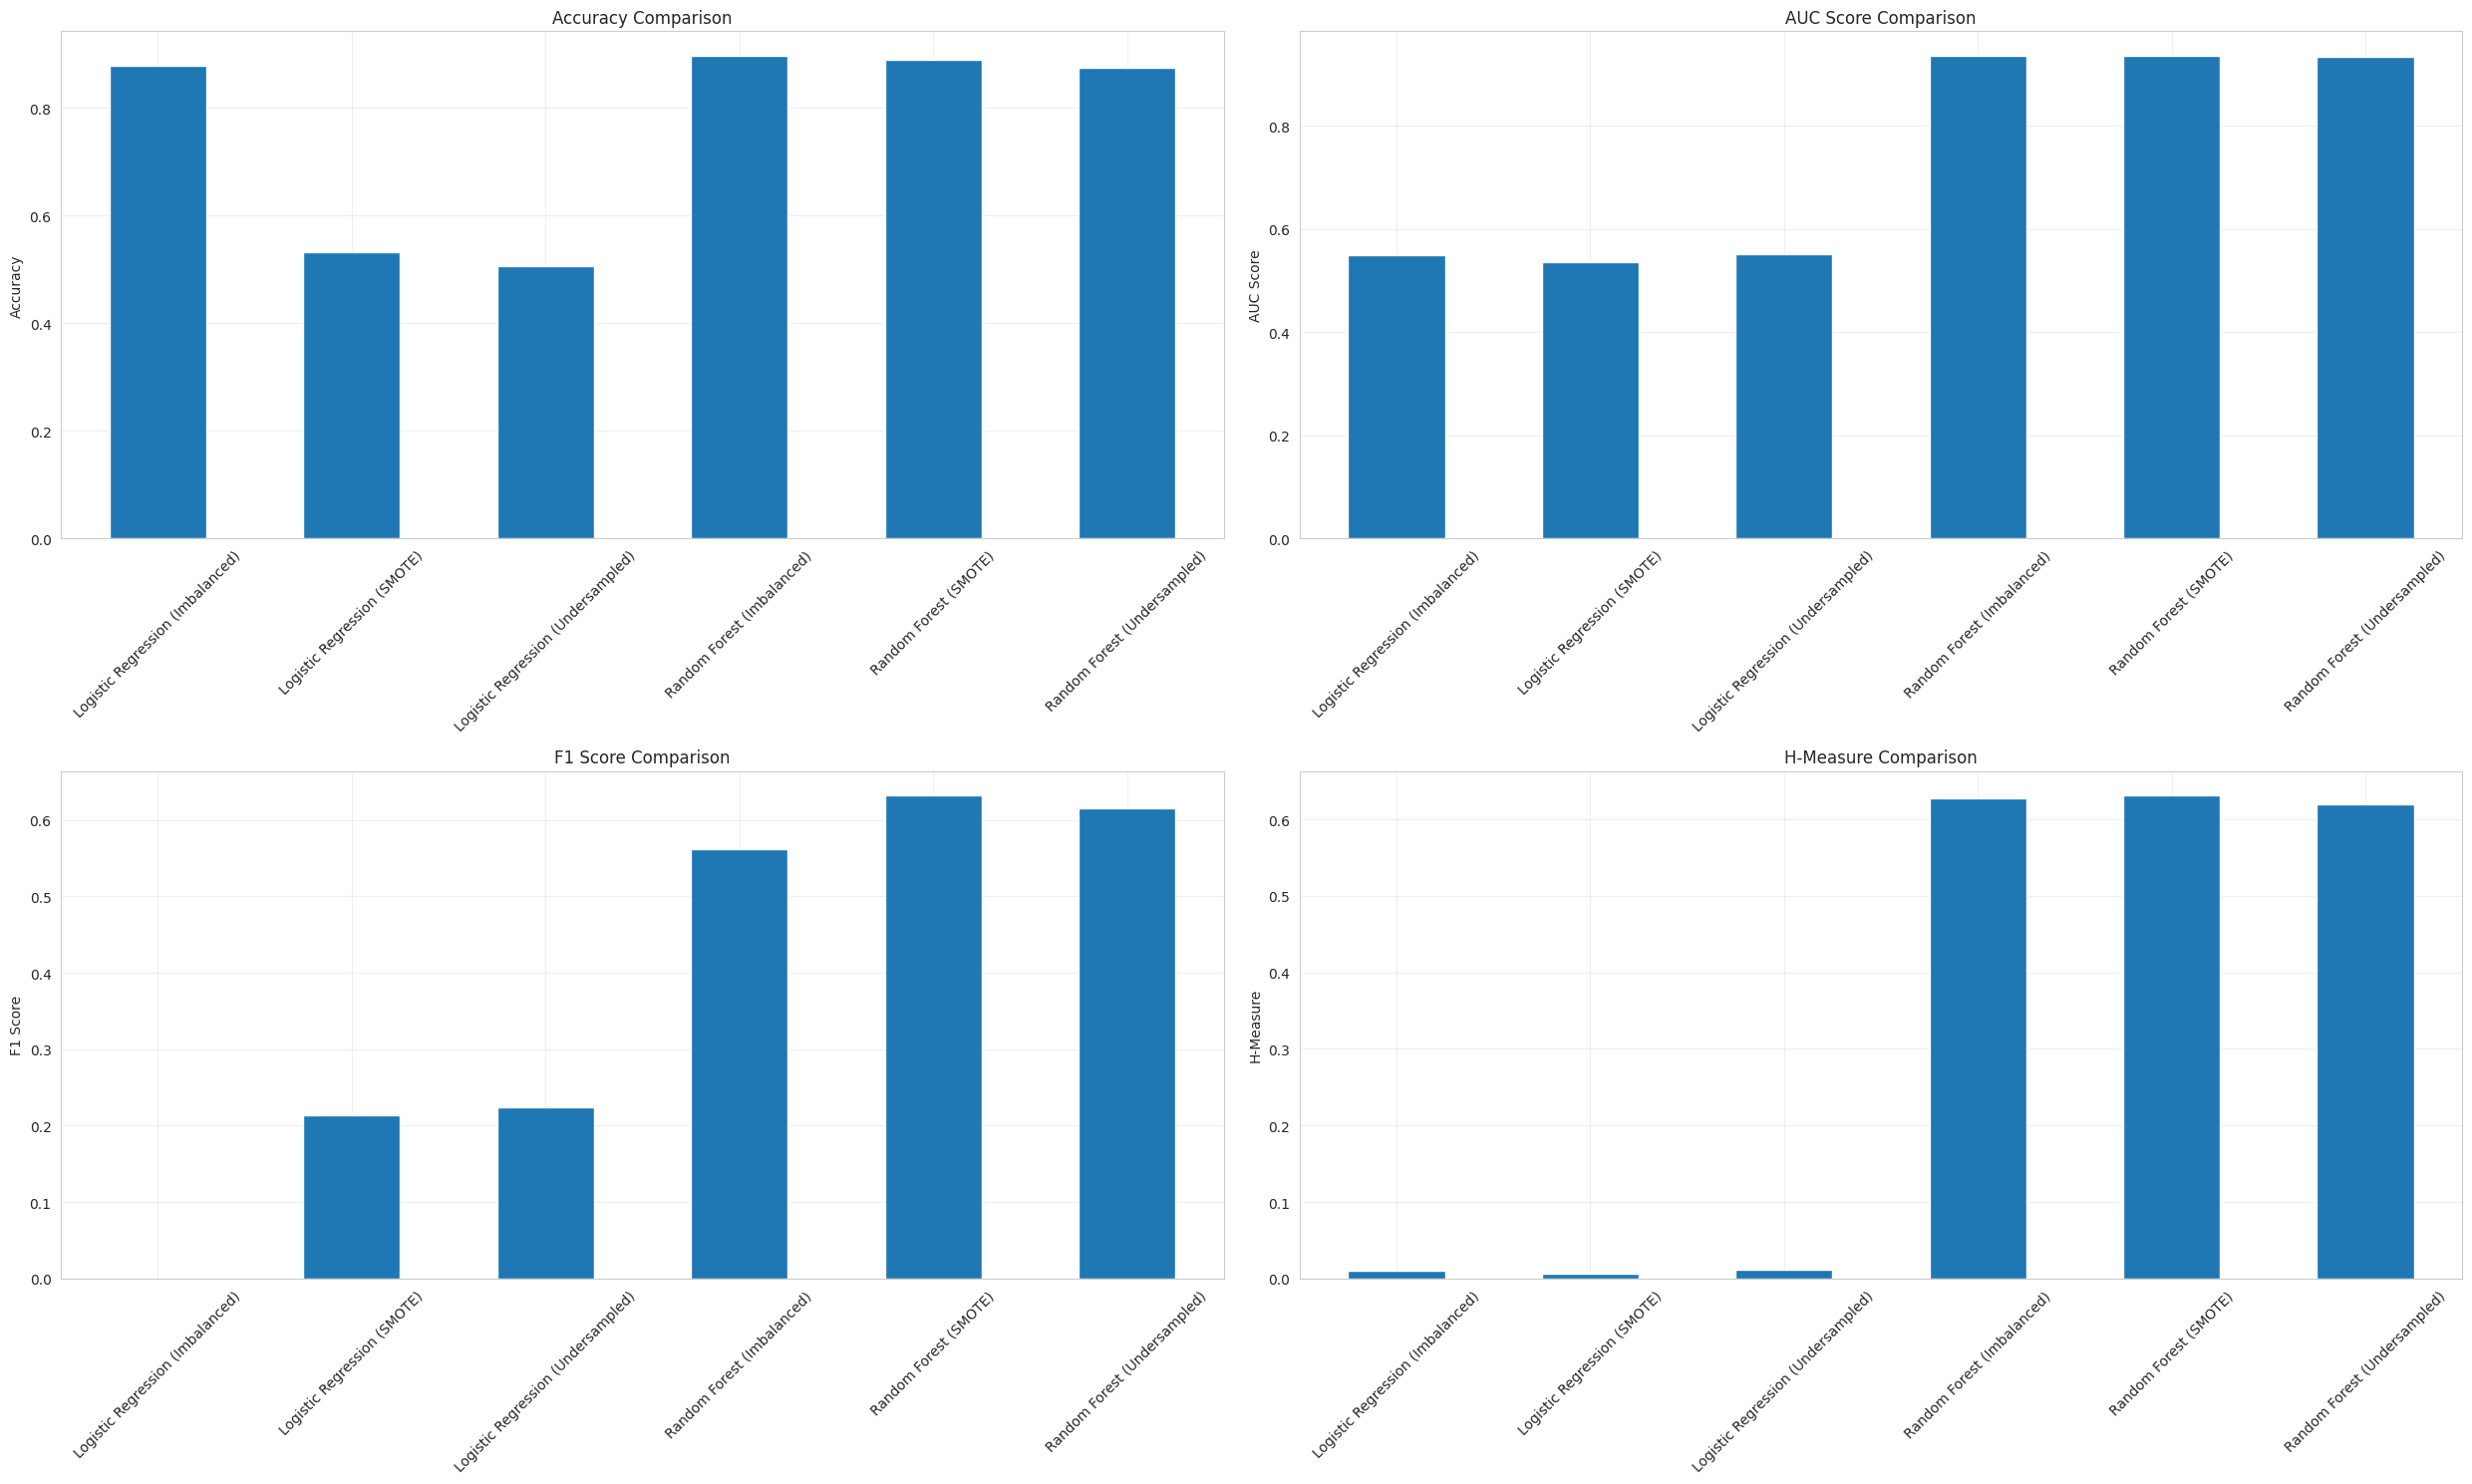

In [129]:
# =============================================================================
# COMPARE ALL MODELS
# =============================================================================

print("\n\nMODEL COMPARISON SUMMARY")
print("="*80)

# Collect all results
all_results = {
    'Logistic Regression (Imbalanced)': lr_imbalanced_results,
    'Logistic Regression (SMOTE)': lr_balanced_smote_results,
    'Logistic Regression (Undersampled)': lr_balanced_under_results,
    'Random Forest (Imbalanced)': rf_imbalanced_results,
    'Random Forest (SMOTE)': rf_balanced_smote_results,
    'Random Forest (Undersampled)': rf_balanced_under_results
}

# Create comparison dataframe
comparison_df = pd.DataFrame({
    model_name: {
        'Accuracy': results['accuracy'],
        'AUC Score': results['auc_score'],
        'F1 Score': results['f1_score'],
        'H-Measure': results['h_measure']
    }
    for model_name, results in all_results.items()
}).T

print(comparison_df.round(4))

# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(25, 15))
metrics = ['Accuracy', 'AUC Score', 'F1 Score', 'H-Measure']

for i, metric in enumerate(metrics):
    ax = axes[i//2, i%2]
    comparison_df[metric].plot(kind='bar', ax=ax)
    ax.set_title(f'{metric} Comparison')
    ax.set_ylabel(metric)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [133]:
# =============================================================================
# INSIGHTS AND RECOMMENDATIONS
# =============================================================================

print("\n\nBUSINESS INSIGHTS AND RECOMMENDATIONS")
print("="*80)

# Best performing model
best_model_name = comparison_df['H-Measure'].idxmax()
best_h_measure = comparison_df['H-Measure'].max()
best_auc = comparison_df.loc[comparison_df['H-Measure'].idxmax(), 'AUC Score']

print(f"Best Performing Model: {best_model_name}")
print(f"Best H-Measure: {best_h_measure:.4f}")
print(f"Corresponding AUC Score: {best_auc:.4f}")

# Feature importance insights (using the best Random Forest model)
if 'Random Forest' in best_model_name:
    if 'SMOTE' in best_model_name:
        best_rf_model = rf_balanced_smote
    elif 'Undersampled' in best_model_name:
        best_rf_model = rf_balanced_under
    else:
        best_rf_model = rf_imbalanced

    print(f"\nTop Risk Factors (Feature Importance):")
    top_features = feature_importance.head(5)
    for idx, row in top_features.iterrows():
        print(f"- {row['feature']}: {row['importance']:.4f}")

print(f"\nModel Performance Summary:")
print(f"- The dataset shows a natural imbalance (12.3% default rate)")
print(f"- H-measure is specifically designed for imbalanced datasets")
print(f"- Balancing techniques show different trade-offs:")
print(f"  * SMOTE generally improves recall for minority class")
print(f"  * Undersampling reduces training time but may lose information")
print(f"- Random Forest models generally outperform Logistic Regression")
print(f"- Consider business cost of false positives vs false negatives when choosing final model")




BUSINESS INSIGHTS AND RECOMMENDATIONS
Best Performing Model: Random Forest (SMOTE)
Best H-Measure: 0.6312
Corresponding AUC Score: 0.9362

Top Risk Factors (Feature Importance):
- Income: 0.1156
- Income_to_Age_ratio: 0.1154
- CITY_encoded: 0.1106
- Profession_encoded: 0.0965
- Residence_Stability: 0.0958

Model Performance Summary:
- The dataset shows a natural imbalance (12.3% default rate)
- H-measure is specifically designed for imbalanced datasets
- Balancing techniques show different trade-offs:
  * SMOTE generally improves recall for minority class
  * Undersampling reduces training time but may lose information
- Random Forest models generally outperform Logistic Regression
- Consider business cost of false positives vs false negatives when choosing final model


In [134]:
# Save the best model (example)
import joblib
if 'Random Forest' in best_model_name and 'SMOTE' in best_model_name:
    joblib.dump(rf_balanced_smote, 'best_loan_default_model.pkl')
    joblib.dump(scaler, 'feature_scaler.pkl')
    print(f"\nBest model saved as 'best_loan_default_model.pkl'")
    print(f"Feature scaler saved as 'feature_scaler.pkl'")

['best_loan_default_model.pkl']

['feature_scaler.pkl']


Best model saved as 'best_loan_default_model.pkl'
Feature scaler saved as 'feature_scaler.pkl'
